In [ ]:
%pip install -q petals bibtexparser pybtex colorama tabulate==0.9.0 pylcs rouge-score datasets

In [ ]:
import os
import math
import heapq
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pylcs
import json
import nltk
import warnings
warnings.filterwarnings('ignore')

from typing import Callable, List
from transformers import BloomTokenizerFast, DebertaForSequenceClassification, DebertaTokenizer
from petals import DistributedBloomForCausalLM
from dataclasses import dataclass
from tqdm.notebook import trange
from tabulate import tabulate, SEPARATING_LINE
from colorama import Fore
from rouge_score import rouge_scorer
from collections import defaultdict
from sklearn.metrics import roc_auc_score
from datasets import load_dataset

In [ ]:
# load model

MODEL_NAME = "bigscience/bloomz-petals"
tokenizer = BloomTokenizerFast.from_pretrained(MODEL_NAME)
model = DistributedBloomForCausalLM.from_pretrained(MODEL_NAME)
model = model.cuda()

## Uncertanty estimation using CPMI

Will use the following formula (from the [CPMI paper](https://arxiv.org/pdf/2210.13210.pdf)) for greedy text generation:

$\text{score}(y | y_{<t}, x) = \log p(y | y_{<t}, x) - \lambda \cdot \mathbb{1} \left\{H(p(. | y_{<t}, x)) \ge \tau\right\} \cdot \log p(y | y_{<t})$

Experimented with following hyperparameters:

* $\lambda = 0, \tau = 0$: without marginal term

* $\lambda = 0.0656, \tau = 3.599$: best hyperparameters from paper (for BARTS2S)

Used 2 different estimates of uncertalty for each token:

* $\arg\max\limits_{y_t} \text{score}(y_t | y_{<t}, x)$

* $H \left(\text{score}(. | y_{<t}, x)\right)$

In [ ]:
# from transformers.generation_logits_process import LogitsProcessor

# class MyCustomLogitsProcessor(LogitsProcessor):
#     def __init__(self):
#         pass

#     def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor):
#         return scores

# inputs = tokenizer('Hello', return_tensors="pt")["input_ids"].cuda()
# outputs = model.generate(inputs, max_new_tokens=10, logits_processor=MyCustomLogitsProcessor())

In [ ]:
# Greedy inference implementation (model.generate doesn't work with custom LogitsProcessor :()

def calculate_logits(session, model, new_token):
    embs = model.transformer.word_embeddings(new_token)
    embs = model.transformer.word_embeddings_layernorm(embs)
    h = session.step(embs)
    h_last = model.transformer.ln_f(h[:, -1])
    logits = model.lm_head(h_last).reshape(-1)
    return F.log_softmax(logits, dim=-1)
  
def calculate_entropy(logits):
    normalized_logits = F.log_softmax(logits, dim=-1)
    return -(normalized_logits * normalized_logits.exp()).sum()

def greedy_inference(
    model, tokenizer,
    input: torch.LongTensor, max_new_tokens: int,
    lambd: float, tau: float,
    verbose: bool = False,
):
    max_tokens = input.shape[-1] + max_new_tokens
    assert input.shape[0] == 1, 'Batch_size should be 1'
    with torch.inference_mode():
        with model.inference_session(max_length=max_tokens) as sess_conditional:  # for calculating p(y_t | x, y_1...y_t-1) 
            with model.inference_session(max_length=max_tokens) as sess_marginal:  # for calculating p(y_t | y_1...y_t-1)
                conditional_tokens = input
                marginal_tokens = torch.LongTensor([[tokenizer.bos_token_id]]).cuda()
                tokens_list, scores_list, entropies_list = [], [], []

                for iter in trange(max_new_tokens, leave=False):
                    conditional_logits = calculate_logits(
                        sess_conditional, model, conditional_tokens)  # p(y_t | x, y_1...y_t-1)
                    if lambd > 0:
                        marginal_logits = calculate_logits(
                            sess_marginal, model, marginal_tokens)  # p(y_t | y_1...y_t-1)
                    
                    # calculate score from logits (CPMI formula)
                    score = conditional_logits
                    if lambd > 0 and calculate_entropy(conditional_logits) >= tau:
                        score -= lambd * marginal_logits

                    new_token = score.argmax()
                    tokens_list.append(new_token)
                    scores_list.append(score.max().item())
                    entropies_list.append(calculate_entropy(score).item())

                    conditional_tokens = new_token.reshape(1, 1)
                    marginal_tokens = new_token.reshape(1, 1)

                    if verbose:
                        print('Iteration {}:\t{}'.format(iter, tokenizer.decode(tokens_list)))
                    
                    if new_token == tokenizer.eos_token_id:
                        break
    
    return tokens_list, np.array(scores_list), np.array(entropies_list)

In [ ]:
# experiment utils

def apply_colors(decoded_tokens, scores_list, score_bounds, colors):
    colored = []
    for score, token in zip(scores_list, decoded_tokens):
        if score_bounds is not None and colors is not None:
            for b, c in zip(score_bounds, colors):
                if b >= score:
                    token = c + token + Fore.RESET
                    break
        colored.append(token)
    return colored

def print_tokens_with_uncertanties(
    tokenizer, tokens_list, scores_list, entropies_list,
    score_bounds=None, entropy_bounds=None, colors=None,
):
    decoded_tokens = [tokenizer.decode([t]) for t in tokens_list]
    print(tabulate([
        [''] + apply_colors(decoded_tokens, scores_list, score_bounds, colors),
        ['max(score)'] + ['%s' % float('%.3g' % score) for score in scores_list],
        SEPARATING_LINE,
        [''] + apply_colors(decoded_tokens, -entropies_list, -entropy_bounds, colors),
        ['H(scores)'] + ['%s' % float('%.3g' % ent) for ent in entropies_list]
    ]))

def mark_bins(patches, bins, score_bounds, colors):
    for i in range(len(patches)):
        for b, c in zip(score_bounds, colors):
            if bins[i] <= b:
                patches[i].set_facecolor(c)
                break

@dataclass
class ModelOutput:
    text: str
    tokenized_text: List[int]
    scores: List[float]
    entropies: List[float]

def experiment(model, tokenizer, text_query, expected_answer, lambd, tau, max_new_tokens=100):
    print('=' * 100)
    print('Lambda = {}, Tau = {}'.format(lambd, tau))

    inputs = tokenizer(text_query, return_tensors="pt")["input_ids"].cuda()
    output_tokens, output_scores, output_entropies = greedy_inference(
        model, tokenizer, inputs, max_new_tokens, lambd, tau)

    output = ModelOutput(
        tokenizer.decode(output_tokens),
        output_tokens,
        output_scores.tolist(),
        output_entropies.tolist())

    print('Query:', text_query)
    print('Expected answer:', expected_answer)
    print('Answer:', tokenizer.decode(output_tokens))
    print()

    Q1_score, Q2_score = -2.0, -1.5
    Q1_ent, Q2_ent = 4.0, 5.5
    print_tokens_with_uncertanties(
        tokenizer, output_tokens, output_scores, output_entropies,
        score_bounds=np.array([Q1_score, Q2_score, math.inf]),
        entropy_bounds=np.array([Q2_ent, Q1_ent, -math.inf]),
        colors=[Fore.RED, Fore.YELLOW, Fore.GREEN])

    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    _, bins, patches = ax1.hist(output_scores)
    ax1.set_xlabel('$score(y_t | y_{<t}, x)$')
    ax1.set_title('Scores histogram')
    mark_bins(patches, bins, [Q1_score, Q2_score, math.inf], ['r', 'y', 'g'])
    _, bins, patches = ax2.hist(output_entropies)
    ax2.set_xlabel('$H(. | y_{<t}, x)$')
    ax2.set_title('Entropies histogram')
    mark_bins(patches, [-b for b in bins], [-Q2_ent, -Q1_ent, math.inf], ['r', 'y', 'g'])
    
    plt.show()

    return output

### TriviaQA dataset

In [ ]:
# load TriviaQA dataset

if not os.path.exists('qa'):
    !wget http://nlp.cs.washington.edu/triviaqa/data/triviaqa-rc.tar.gz
    !tar -xf triviaqa-rc.tar.gz

with open('qa/web-train.json') as f:
    triviaqa = json.load(f)

@dataclass
class TriviaQASample:
    question: str
    answer: str

    def gen_model_input(self):
        return self.question

    def gen_p_true_question(self, proposed_answer):
        return 'Question: "{}". Proposed Answer: "{}". Is the proposed answer True or False?'\
            .format(self.question, proposed_answer)

triviaqa_samples = []
for sample in triviaqa['Data']:
    triviaqa_samples.append(TriviaQASample(sample['Question'], sample['Answer']['Value']))

print(len(triviaqa_samples))
print(triviaqa_samples[0].gen_model_input())
print(triviaqa_samples[0].answer)

--2023-03-26 00:26:22--  http://nlp.cs.washington.edu/triviaqa/data/triviaqa-rc.tar.gz
Resolving nlp.cs.washington.edu (nlp.cs.washington.edu)... 128.208.3.120, 2607:4000:200:12::78
Connecting to nlp.cs.washington.edu (nlp.cs.washington.edu)|128.208.3.120|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2665779500 (2.5G) [application/x-gzip]
Saving to: ‘triviaqa-rc.tar.gz’

triviaqa-rc.tar.gz  100%[===================>]   2.48G  29.9MB/s    in 86s     

2023-03-26 00:27:48 (29.6 MB/s) - ‘triviaqa-rc.tar.gz’ saved [2665779500/2665779500]

76496
Which American-born Sinclair won the Nobel Prize for Literature in 1930?
Sinclair Lewis


Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Who is the patron saint of mountaineers?
Expected answer: Saint Bernard
Answer:  Saint Christopher</s>

----------  ------  ------------  -------
             Saint   Christopher  </s>
max(score)  -1.11   -0.926        -0.0156
----------  ------  ------------  -------
             Saint   Christopher  </s>
H(scores)   3.39    2.91          0.134
----------  ------  ------------  -------


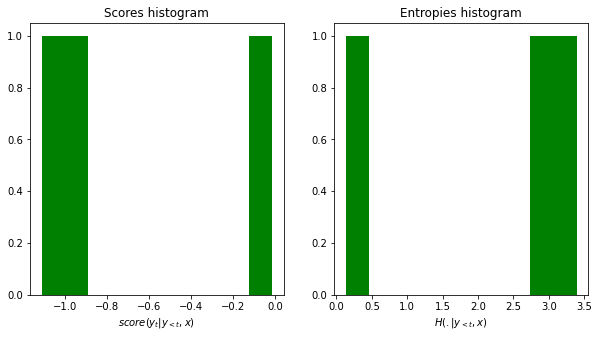

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Who is the patron saint of mountaineers?
Expected answer: Saint Bernard
Answer:  Saint Christopher</s>

----------  ------  ------------  -------
             Saint   Christopher  </s>
max(score)  -1.11   -0.926        -0.0156
----------  ------  ------------  -------
             Saint   Christopher  </s>
H(scores)   3.39    2.91          0.134
----------  ------  ------------  -------


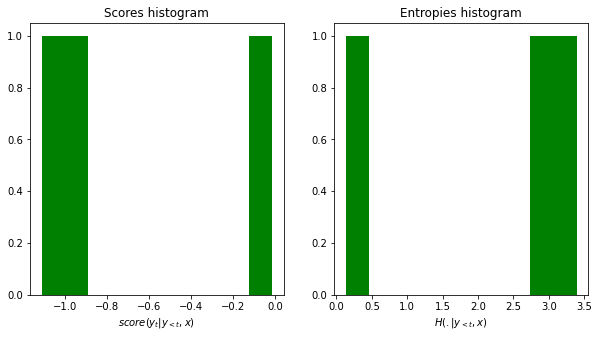

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: At what weight did boxer Chris Eubank win the WBO title in 1990?
Expected answer: Middleweight
Answer:  light heavyweight</s>

----------  ------  ------  -------  -------
             light   heavy  weight   </s>
max(score)  -1.21   -1.16   -0.0415  -0.0189
----------  ------  ------  -------  -------
             light   heavy  weight   </s>
H(scores)   3.7     1.98    0.237    0.147
----------  ------  ------  -------  -------


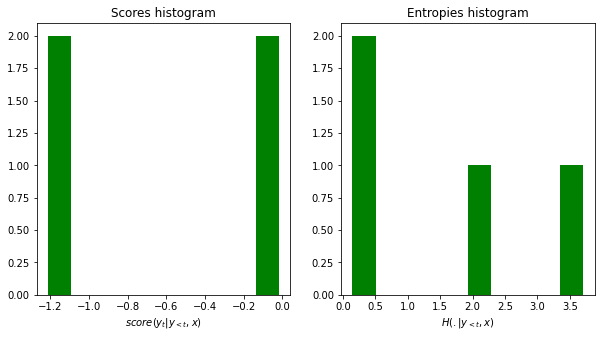

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: At what weight did boxer Chris Eubank win the WBO title in 1990?
Expected answer: Middleweight
Answer:  light heavyweight</s>

----------  ------  ------  -------  -------
             light   heavy  weight   </s>
max(score)  -0.566  -1.16   -0.0427  -0.0193
----------  ------  ------  -------  -------
             light   heavy  weight   </s>
H(scores)   3.88    1.98    0.246    0.151
----------  ------  ------  -------  -------


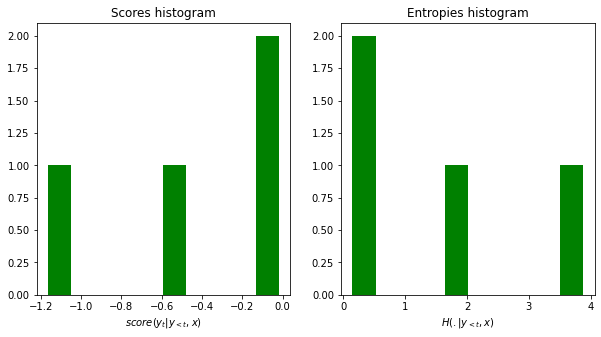

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Oscar Deutsch founded which cinema chain in 1930, taking the name from the Greek word for amphitheatre?
Expected answer: Odeon
Answer:  Odeon</s>

----------  ------  -------  ------
             Ode    on       </s>
max(score)  -0.103  -0.0427  -0.385
----------  ------  -------  ------
             Ode    on       </s>
H(scores)   0.816   0.287    1.72
----------  ------  -------  ------


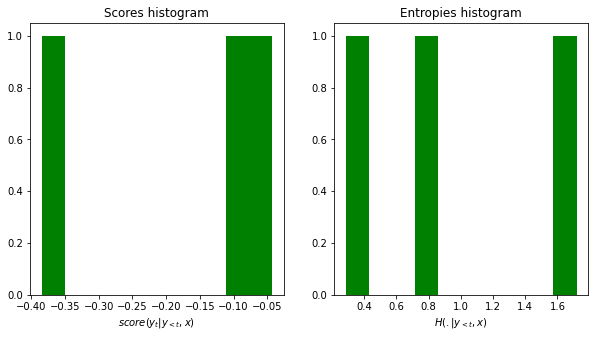

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Oscar Deutsch founded which cinema chain in 1930, taking the name from the Greek word for amphitheatre?
Expected answer: Odeon
Answer:  Odeon</s>

----------  ------  -------  ------
             Ode    on       </s>
max(score)  -0.105  -0.0488  -0.369
----------  ------  -------  ------
             Ode    on       </s>
H(scores)   0.832   0.309    1.66
----------  ------  -------  ------


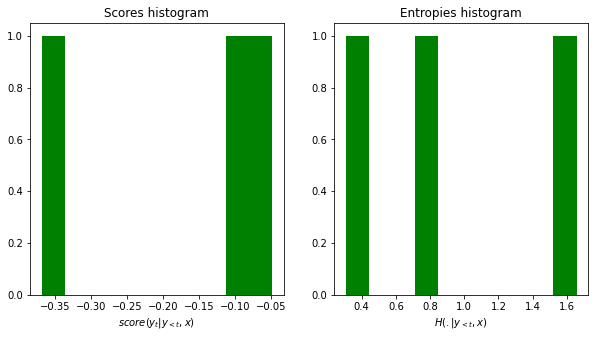

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Jerzy Buzek was elected Prime Minister of which European country in October 1997?
Expected answer: Poland
Answer:  Poland</s>

----------  -------  --------
             Poland  </s>
max(score)  -0.252   -0.00174
----------  -------  --------
             Poland  </s>
H(scores)   1.22     0.0181
----------  -------  --------


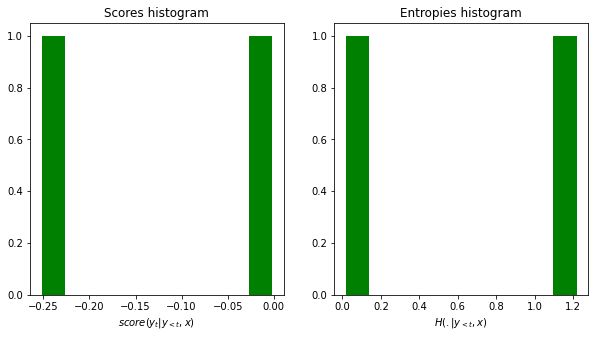

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Jerzy Buzek was elected Prime Minister of which European country in October 1997?
Expected answer: Poland
Answer:  Poland</s>

----------  -------  --------
             Poland  </s>
max(score)  -0.243   -0.00182
----------  -------  --------
             Poland  </s>
H(scores)   1.17     0.0189
----------  -------  --------


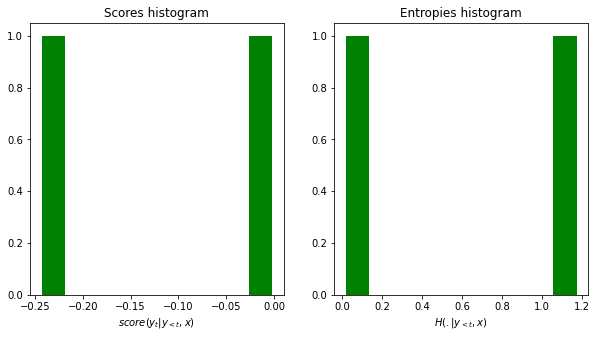

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: What is the largest desert in Asia?
Expected answer: Gobi
Answer:  Gobi</s>

----------  -----  --------  ------
             G     obi       </s>
max(score)  -1.36  -0.00418  -0.719
----------  -----  --------  ------
             G     obi       </s>
H(scores)   3.11   0.0352    0.902
----------  -----  --------  ------


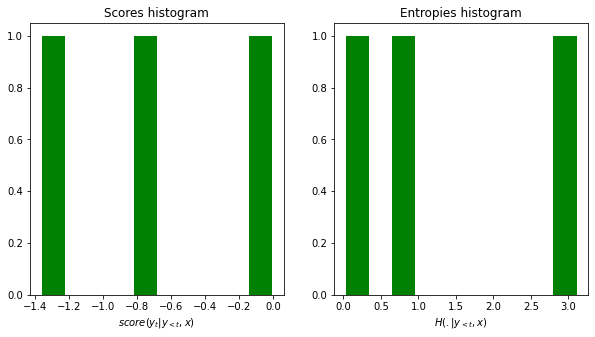

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: What is the largest desert in Asia?
Expected answer: Gobi
Answer:  Gobi</s>

----------  -----  --------  ------
             G     obi       </s>
max(score)  -1.32  -0.00412  -0.719
----------  -----  --------  ------
             G     obi       </s>
H(scores)   3.14   0.0344    0.91
----------  -----  --------  ------


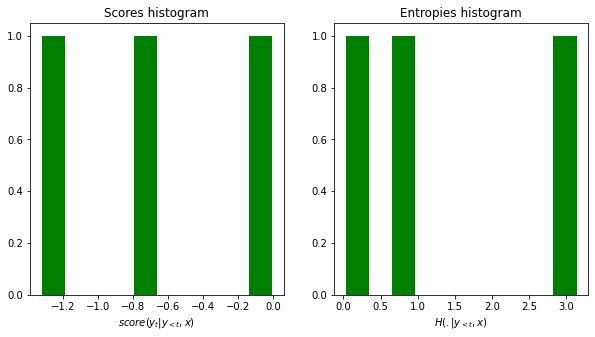

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Who was the first National Hunt jockey to ride more than 3000 winners?
Expected answer: A P McCoy
Answer:  Lester Keith Piggott</s>

----------  -------  ------  -------  ---------  --------  -------
             Lester   Keith   P       igg        ott       </s>
max(score)  -0.945   -0.242  -0.0791  -0.000173  -0.00203  -0.0244
----------  -------  ------  -------  ---------  --------  -------
             Lester   Keith   P       igg        ott       </s>
H(scores)   3.72     0.922   0.465    0.00243    0.0153    0.162
----------  -------  ------  -------  ---------  --------  -------


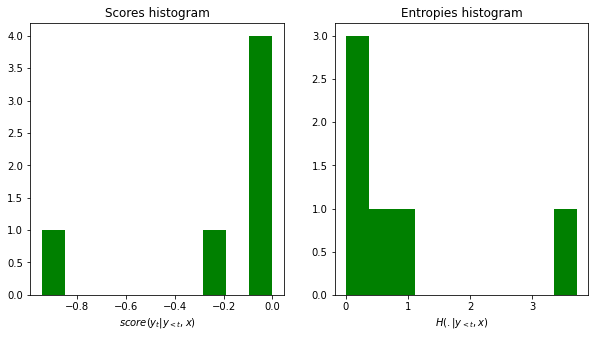

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Who was the first National Hunt jockey to ride more than 3000 winners?
Expected answer: A P McCoy
Answer:  Lester Keith Piggott</s>

----------  -------  ------  -------  ---------  --------  -------
             Lester   Keith   P       igg        ott       </s>
max(score)  0.0625   -0.299  -0.0654  -0.000166  -0.00204  -0.0262
----------  -------  ------  -------  ---------  --------  -------
             Lester   Keith   P       igg        ott       </s>
H(scores)   3.55     1.04    0.41     0.00235    0.0154    0.171
----------  -------  ------  -------  ---------  --------  -------


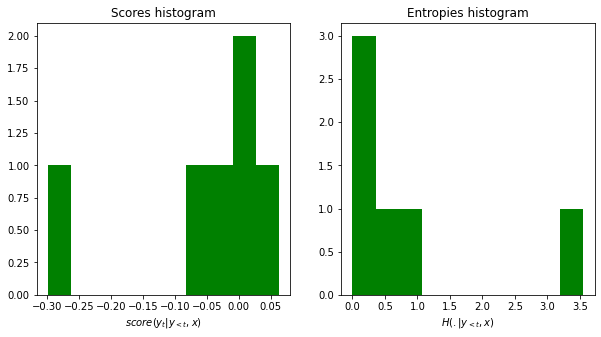

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Which element takes its name from the Greek word for 'light bearer'?
Expected answer: PHOSPHORUS
Answer:  Photon</s>

----------  -----  ------  -------
             Phot  on      </s>
max(score)  -2.44  -0.422  -0.0439
----------  -----  ------  -------
             Phot  on      </s>
H(scores)   5.5    2.23    0.432
----------  -----  ------  -------


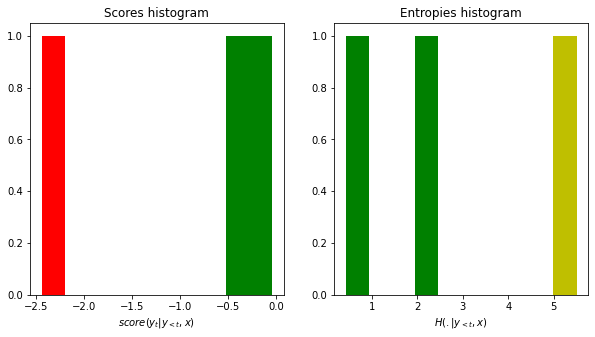

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Which element takes its name from the Greek word for 'light bearer'?
Expected answer: PHOSPHORUS
Answer:  Photon</s>

----------  -----  ------  -------
             Phot  on      </s>
max(score)  -1.55  -0.422  -0.0439
----------  -----  ------  -------
             Phot  on      </s>
H(scores)   5.62   2.23    0.432
----------  -----  ------  -------


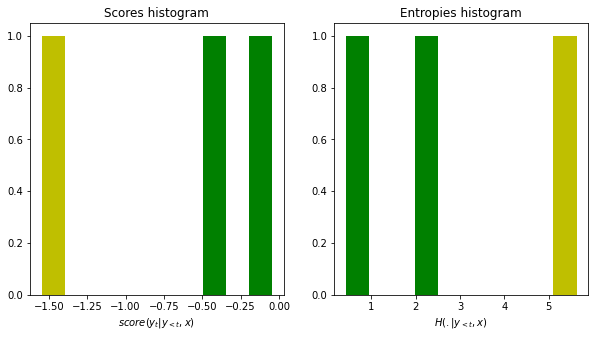

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Which Andre Lloyd-Webber musical was banned in South Africa in the 1970’s?
Expected answer: Jesus Christ Superstar
Answer:  Jesus Christ Superstar</s>

----------  ------  ---------  ------  ---------  --------  -------
             Jesus   Christ     Sup    erst       ar        </s>
max(score)  -0.848  -0.000923  -0.218  -0.000119  -0.00288  -0.0128
----------  ------  ---------  ------  ---------  --------  -------
             Jesus   Christ     Sup    erst       ar        </s>
H(scores)   3.28    0.0094     0.75    0.00132    0.0248    0.116
----------  ------  ---------  ------  ---------  --------  -------


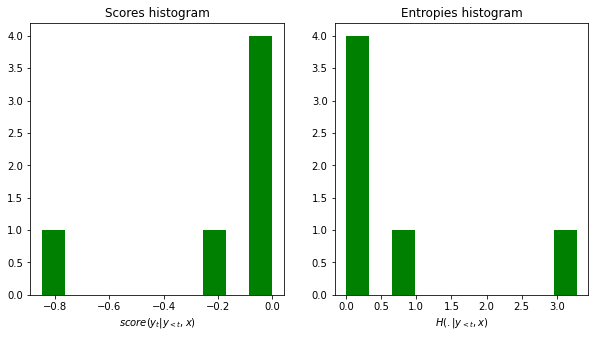

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Which Andre Lloyd-Webber musical was banned in South Africa in the 1970’s?
Expected answer: Jesus Christ Superstar
Answer:  Jesus Christ Superstar</s>

----------  ------  ---------  ------  ---------  --------  -------
             Jesus   Christ     Sup    erst       ar        </s>
max(score)  -0.848  -0.000923  -0.218  -0.000119  -0.00288  -0.0128
----------  ------  ---------  ------  ---------  --------  -------
             Jesus   Christ     Sup    erst       ar        </s>
H(scores)   3.28    0.0094     0.75    0.00132    0.0248    0.116
----------  ------  ---------  ------  ---------  --------  -------


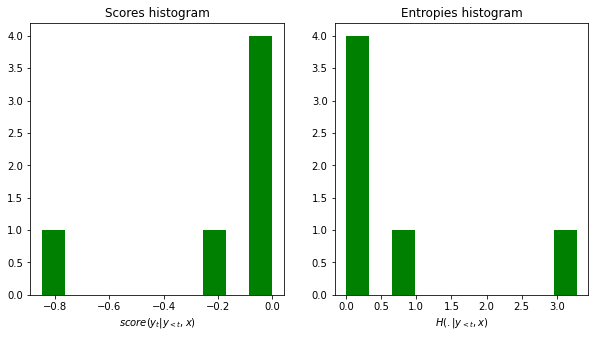

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: What would you be afraid of if you suffered from demophobia?
Expected answer: Crowds
Answer:  Fear of death</s>

----------  -----  -------  ------  -------
             Fear   of       death  </s>
max(score)  -1.49  -0.0728  -1.43   -0.0957
----------  -----  -------  ------  -------
             Fear   of       death  </s>
H(scores)   4.69   0.449    3.83    0.512
----------  -----  -------  ------  -------


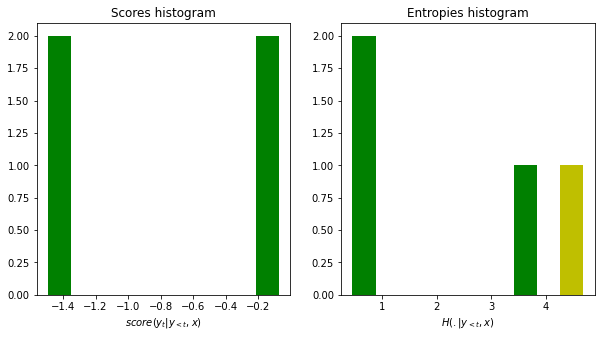

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: What would you be afraid of if you suffered from demophobia?
Expected answer: Crowds
Answer:  Fear of death</s>

----------  -----  -------  ------  -------
             Fear   of       death  </s>
max(score)  -0.52  -0.0728  -1.2    -0.0957
----------  -----  -------  ------  -------
             Fear   of       death  </s>
H(scores)   4.66   0.449    4.22    0.512
----------  -----  -------  ------  -------


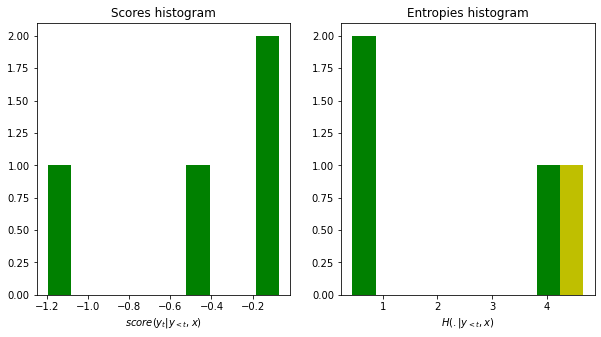

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: How many Victoria Crosses were won at Rorke's Drift in 1879?
Expected answer: Eleven
Answer:  four</s>

----------  -----  -------
             four  </s>
max(score)  -1.8   -0.0237
----------  -----  -------
             four  </s>
H(scores)   3.86   0.211
----------  -----  -------


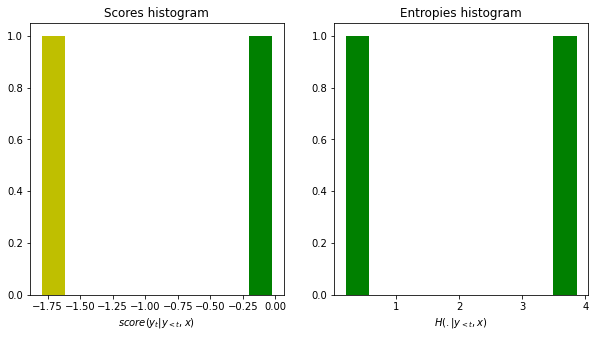

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: How many Victoria Crosses were won at Rorke's Drift in 1879?
Expected answer: Eleven
Answer:  four</s>

----------  -----  -------
             four  </s>
max(score)  -1.06  -0.0237
----------  -----  -------
             four  </s>
H(scores)   3.95   0.211
----------  -----  -------


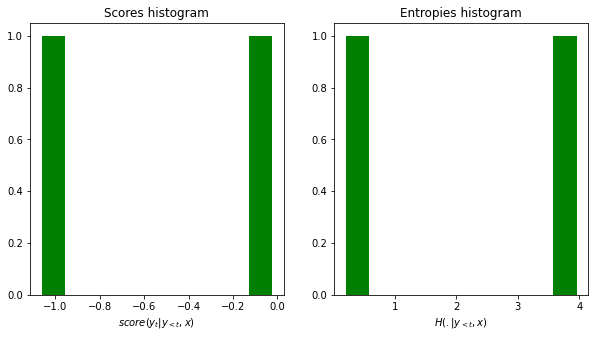

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: In which German town has a month-long festival celebrating the music of Richard Wagner been held every summer since 1876?
Expected answer: BAYREUTH
Answer:  Bayreuth</s>

----------  -------  ------  --------  ------
             Bay     re      uth       </s>
max(score)  -0.0134  -0.355  -0.00117  -0.117
----------  -------  ------  --------  ------
             Bay     re      uth       </s>
H(scores)   0.129    1.9     0.01      0.457
----------  -------  ------  --------  ------


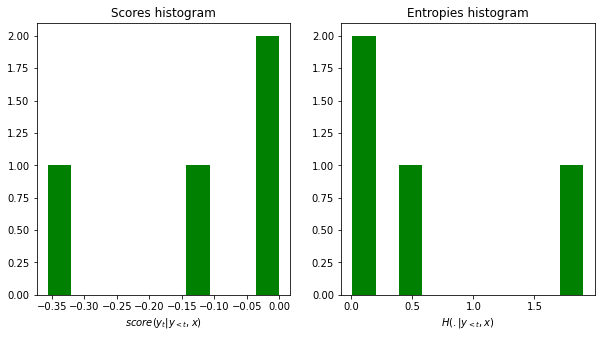

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: In which German town has a month-long festival celebrating the music of Richard Wagner been held every summer since 1876?
Expected answer: BAYREUTH
Answer:  Bayreuth</s>

----------  -------  ------  --------  ------
             Bay     re      uth       </s>
max(score)  -0.0134  -0.355  -0.00117  -0.117
----------  -------  ------  --------  ------
             Bay     re      uth       </s>
H(scores)   0.129    1.9     0.01      0.457
----------  -------  ------  --------  ------


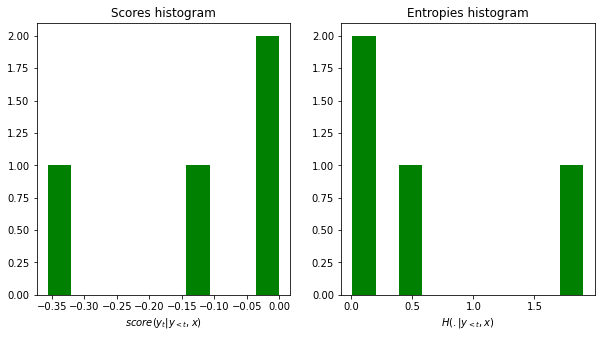

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Which state did Amelia Earhart land in on her first solo Pacific flight?
Expected answer: California
Answer:  Hawaii</s>

----------  -------  --------
             Hawaii  </s>
max(score)  -0.214   -0.00328
----------  -------  --------
             Hawaii  </s>
H(scores)   1.09     0.0302
----------  -------  --------


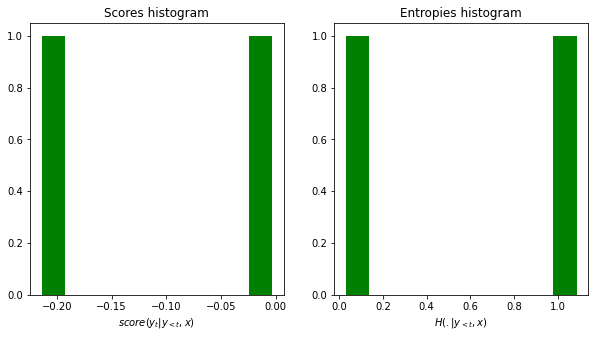

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Which state did Amelia Earhart land in on her first solo Pacific flight?
Expected answer: California
Answer:  Hawaii</s>

----------  -------  --------
             Hawaii  </s>
max(score)  -0.238   -0.00305
----------  -------  --------
             Hawaii  </s>
H(scores)   1.16     0.0283
----------  -------  --------


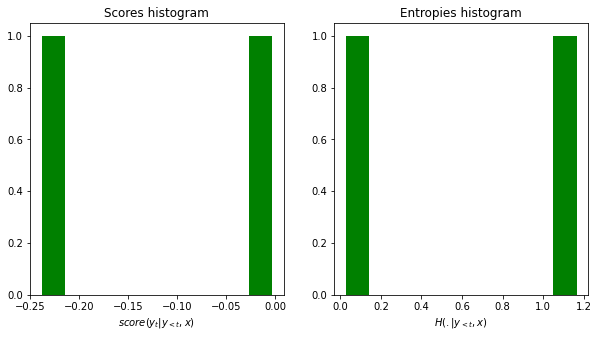

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Which actress played opposite Nicholas Cage in the film 'Captain Corelli's Mandolin'?
Expected answer: PENELOPE CRUZ
Answer:  Penelope Cruz</s>

----------  -------  ------  --------  --------
             Pen     elope    Cruz     </s>
max(score)  -0.0167  -0.645  -0.00748  -0.00818
----------  -------  ------  --------  --------
             Pen     elope    Cruz     </s>
H(scores)   0.167    0.824   0.064     0.0776
----------  -------  ------  --------  --------


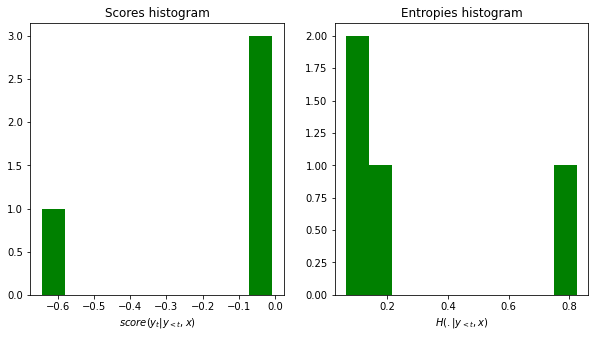

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Which actress played opposite Nicholas Cage in the film 'Captain Corelli's Mandolin'?
Expected answer: PENELOPE CRUZ
Answer:  Penelope Cruz</s>

----------  -------  ------  --------  -------
             Pen     elope    Cruz     </s>
max(score)  -0.0167  -0.645  -0.00693  -0.0083
----------  -------  ------  --------  -------
             Pen     elope    Cruz     </s>
H(scores)   0.169    0.82    0.0593    0.0791
----------  -------  ------  --------  -------


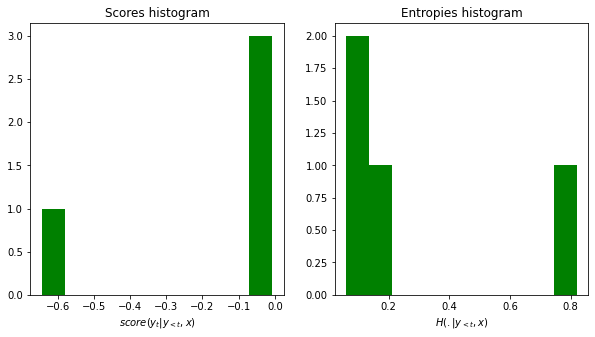

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: In which country is Cape wrath?
Expected answer: SCOTLAND
Answer:  Scotland</s>

----------  ---------  --------
             Scotland  </s>
max(score)  -0.457     -0.00424
----------  ---------  --------
             Scotland  </s>
H(scores)   1.72       0.0383
----------  ---------  --------


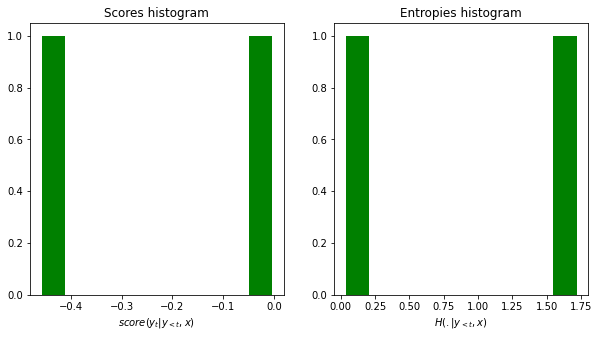

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: In which country is Cape wrath?
Expected answer: SCOTLAND
Answer:  Scotland</s>

----------  ---------  --------
             Scotland  </s>
max(score)  -0.457     -0.00424
----------  ---------  --------
             Scotland  </s>
H(scores)   1.72       0.0383
----------  ---------  --------


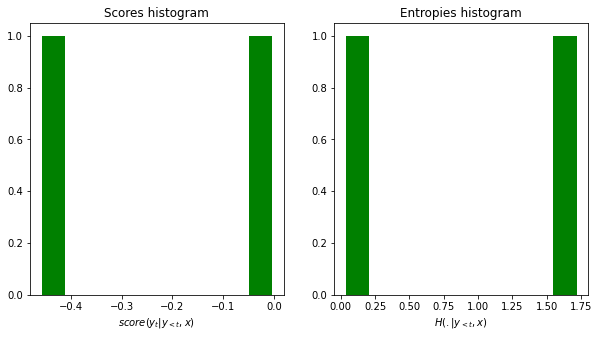

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Originally known as the Daily Universal Register, how is it known today?
Expected answer: THE TIMES
Answer:  The Times</s>

----------  ------  ------  -----
             The     Times  </s>
max(score)  -0.926  -0.214  -0.68
----------  ------  ------  -----
             The     Times  </s>
H(scores)   2.75    1.16    0.992
----------  ------  ------  -----


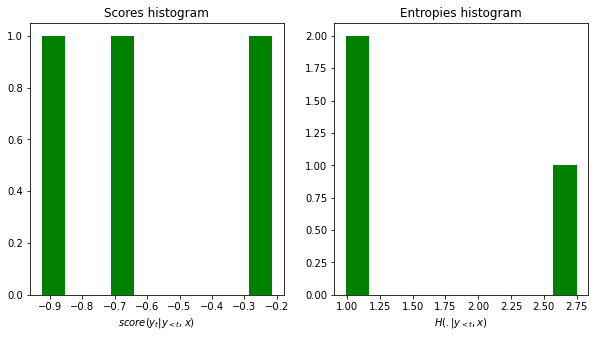

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Originally known as the Daily Universal Register, how is it known today?
Expected answer: THE TIMES
Answer:  The Times</s>

----------  ------  ------  ------
             The     Times  </s>
max(score)  -0.941  -0.212  -0.684
----------  ------  ------  ------
             The     Times  </s>
H(scores)   2.77    1.16    1.01
----------  ------  ------  ------


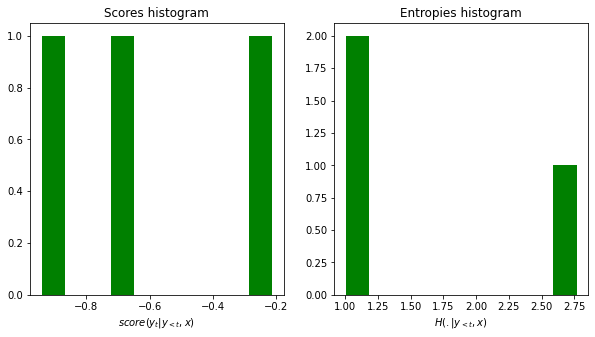

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Which African country gained its independence from Britain on the 30th September 1966?
Expected answer: Botswana
Answer:  Zambia</s>

----------  -------  --------
             Zambia  </s>
max(score)  -2.08    -0.00873
----------  -------  --------
             Zambia  </s>
H(scores)   4.28     0.082
----------  -------  --------


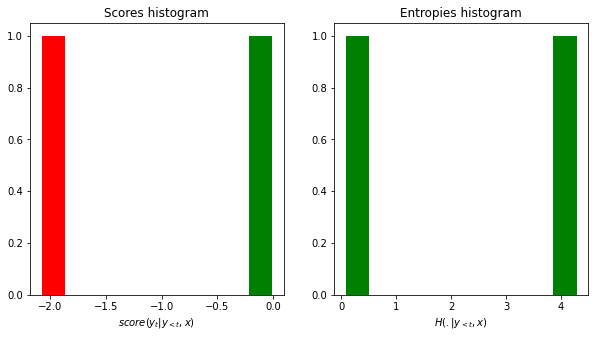

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Which African country gained its independence from Britain on the 30th September 1966?
Expected answer: Botswana
Answer:  Zambia</s>

----------  -------  --------
             Zambia  </s>
max(score)  -1.05    -0.00867
----------  -------  --------
             Zambia  </s>
H(scores)   4.28     0.0815
----------  -------  --------


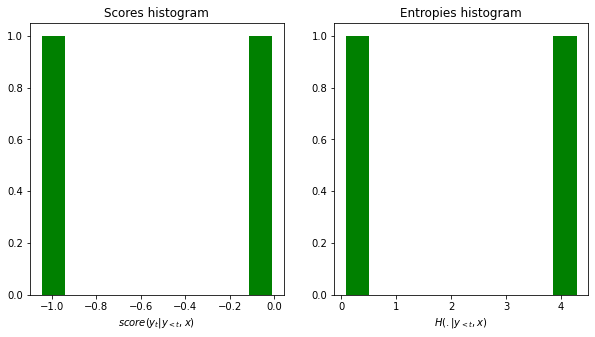

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: What is the title of the 1983 film in which teenager Tom Cruise turns his parents home into a brothel?
Expected answer: Risky Business
Answer:  Risky Business</s>

----------  -------  -------  ---------  --------
             Ris     ky        Business  </s>
max(score)  -0.0366  -0.0015  -0.0339    -0.00345
----------  -------  -------  ---------  --------
             Ris     ky        Business  </s>
H(scores)   0.322    0.0164   0.183      0.0327
----------  -------  -------  ---------  --------


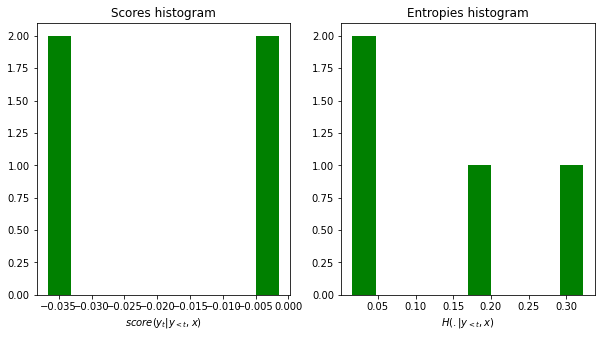

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: What is the title of the 1983 film in which teenager Tom Cruise turns his parents home into a brothel?
Expected answer: Risky Business
Answer:  Risky Business</s>

----------  ------  --------  ---------  -------
             Ris    ky         Business  </s>
max(score)  -0.033  -0.00129  -0.0344    -0.0034
----------  ------  --------  ---------  -------
             Ris    ky         Business  </s>
H(scores)   0.293   0.0142    0.186      0.0322
----------  ------  --------  ---------  -------


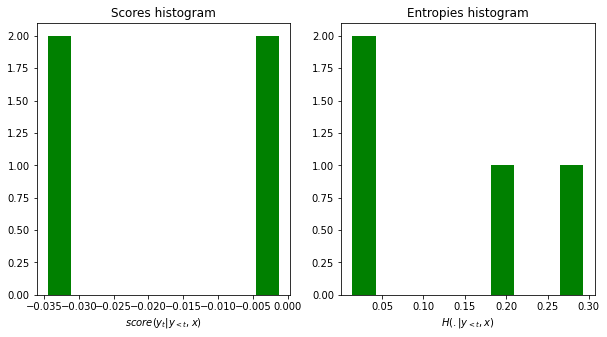

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Which Liverpool film maker made 'Of Time And The City' and 'Deep Blue Sea'?
Expected answer: TERENCE DAVIES
Answer:  Terence Davies</s>

----------  ------  ---------  -------  -------
             Ter    ence        Davies  </s>
max(score)  -0.656  -0.000269  -0.0139  -0.0256
----------  ------  ---------  -------  -------
             Ter    ence        Davies  </s>
H(scores)   2.89    0.00389    0.111    0.19
----------  ------  ---------  -------  -------


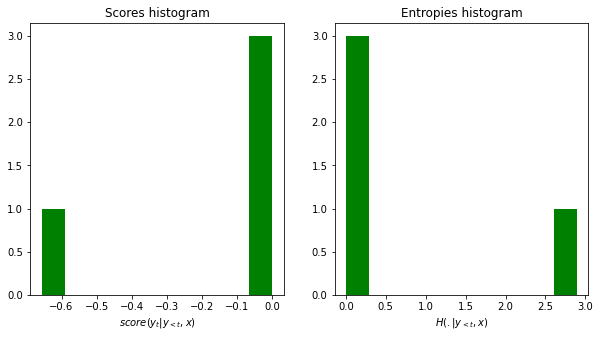

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Which Liverpool film maker made 'Of Time And The City' and 'Deep Blue Sea'?
Expected answer: TERENCE DAVIES
Answer:  Terence Davies</s>

----------  ------  ---------  -------  -------
             Ter    ence        Davies  </s>
max(score)  -0.656  -0.000269  -0.0139  -0.0256
----------  ------  ---------  -------  -------
             Ter    ence        Davies  </s>
H(scores)   2.89    0.00389    0.111    0.19
----------  ------  ---------  -------  -------


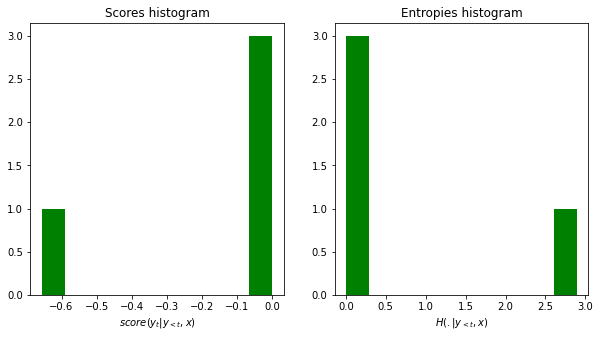

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Which film about figure skaters starred Jon Heder and Will Ferrell?
Expected answer: Blades of Glory
Answer:  The Other Guys</s>

----------  -----  ------  --------  --------  --------
             The    Other   Guy      s         </s>
max(score)  -1.75  -2.02   -0.00583  -0.00214  -0.00352
----------  -----  ------  --------  --------  --------
             The    Other   Guy      s         </s>
H(scores)   5.09   4.91    0.0464    0.0183    0.0339
----------  -----  ------  --------  --------  --------


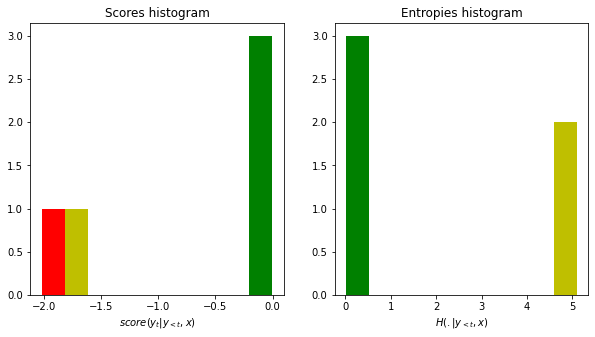

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Which film about figure skaters starred Jon Heder and Will Ferrell?
Expected answer: Blades of Glory
Answer:  The Other Guys</s>

----------  -----  ------  --------  --------  --------
             The    Other   Guy      s         </s>
max(score)  -1.03  -1.58   -0.00507  -0.00163  -0.00371
----------  -----  ------  --------  --------  --------
             The    Other   Guy      s         </s>
H(scores)   5.31   5.03    0.041     0.0145    0.0349
----------  -----  ------  --------  --------  --------


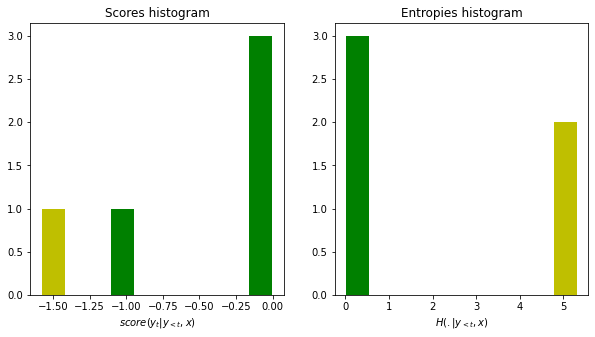

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Ray Bolger played who in The Wizard of Oz?
Expected answer: Scarecrow
Answer:  Scarecrow</s>

----------  -----  --------  -------  -------
             Scar  ec        row      </s>
max(score)  -2.02  -0.00983  -0.0209  -0.0752
----------  -----  --------  -------  -------
             Scar  ec        row      </s>
H(scores)   5.22   0.0757    0.104    0.48
----------  -----  --------  -------  -------


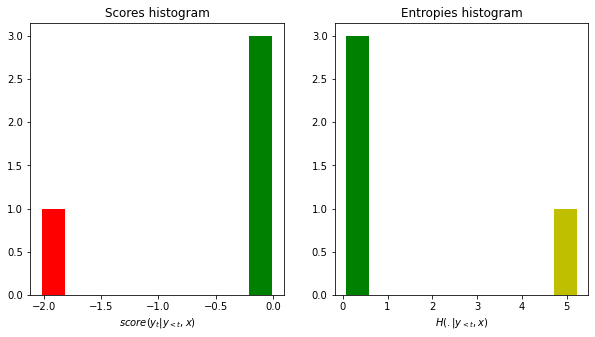

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Ray Bolger played who in The Wizard of Oz?
Expected answer: Scarecrow
Answer:  Scarecrow</s>

----------  -----  -------  -------  -------
             Scar  ec       row      </s>
max(score)  -1.09  -0.0115  -0.0186  -0.0728
----------  -----  -------  -------  -------
             Scar  ec       row      </s>
H(scores)   5.28   0.0869   0.0933   0.459
----------  -----  -------  -------  -------


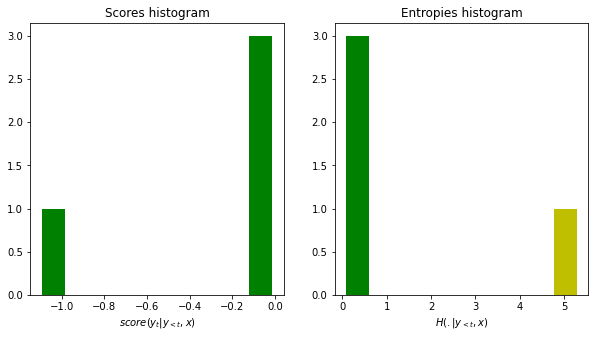

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Omophagy is the eating of what?
Expected answer: Raw meat
Answer:  other cells</s>

----------  ------  ------  -------
             other   cells  </s>
max(score)  -2.69   -0.637  -0.0212
----------  ------  ------  -------
             other   cells  </s>
H(scores)   5.16    1.66    0.165
----------  ------  ------  -------


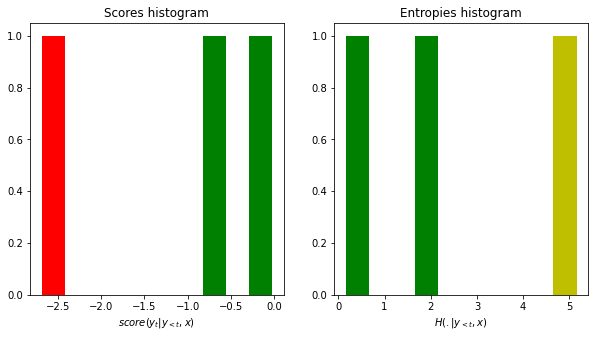

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Omophagy is the eating of what?
Expected answer: Raw meat
Answer:  other cells</s>

----------  ------  ------  -------
             other   cells  </s>
max(score)  -2.06   -0.641  -0.0192
----------  ------  ------  -------
             other   cells  </s>
H(scores)   5.25    1.68    0.151
----------  ------  ------  -------


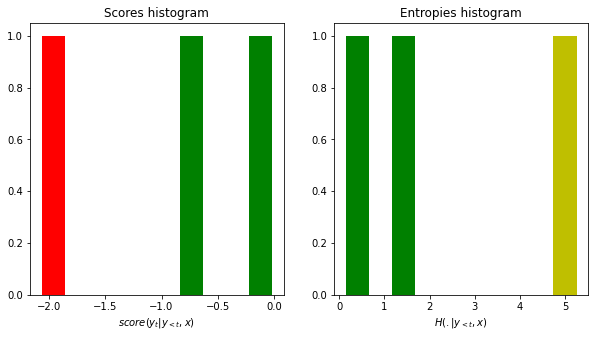

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Which iconic U.S. detective agency used the motto 'We Never Sleep'?
Expected answer: PINKERTONS
Answer:  Pinkertons</s>

----------  -------  ------  --------  -------
             Pink    ert     ons       </s>
max(score)  -0.0549  -0.019  -0.00201  -0.0173
----------  -------  ------  --------  -------
             Pink    ert     ons       </s>
H(scores)   0.352    0.0977  0.0216    0.146
----------  -------  ------  --------  -------


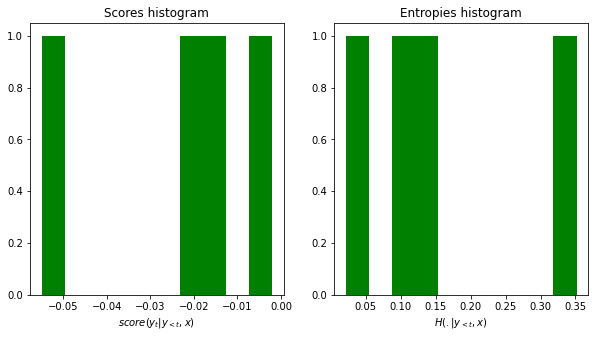

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Which iconic U.S. detective agency used the motto 'We Never Sleep'?
Expected answer: PINKERTONS
Answer:  Pinkertons</s>

----------  -------  ------  --------  -------
             Pink    ert     ons       </s>
max(score)  -0.0549  -0.019  -0.00201  -0.0173
----------  -------  ------  --------  -------
             Pink    ert     ons       </s>
H(scores)   0.352    0.0977  0.0216    0.146
----------  -------  ------  --------  -------


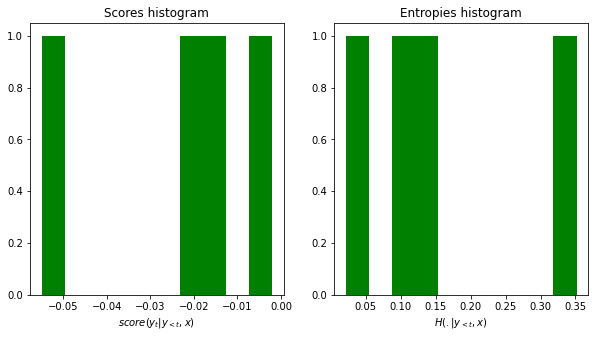

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: In a greyhound race, what colour does the greyhound in trap 3 wear?
Expected answer: White
Answer:  white</s>

----------  ------  ------
             white  </s>
max(score)  -1.86   -0.189
----------  ------  ------
             white  </s>
H(scores)   4.09    0.926
----------  ------  ------


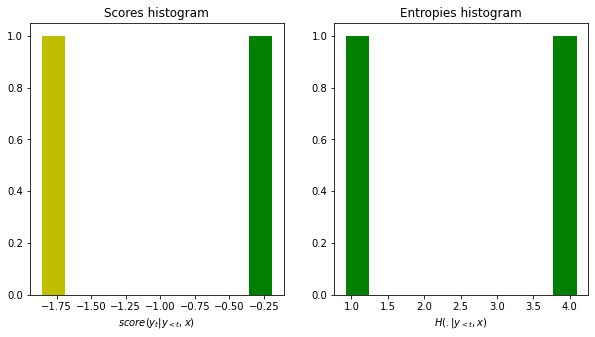

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: In a greyhound race, what colour does the greyhound in trap 3 wear?
Expected answer: White
Answer:  white</s>

----------  ------  ------
             white  </s>
max(score)  -1.2    -0.189
----------  ------  ------
             white  </s>
H(scores)   4.22    0.926
----------  ------  ------


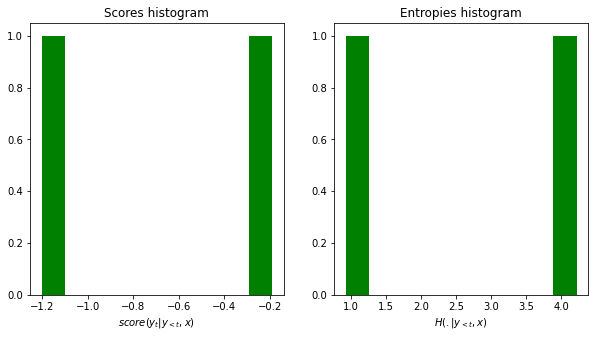

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Which novelist and playwright is commemorated by the Rodin sculpture which stands in the Boulevard Raspail in Paris?
Expected answer: BALZAC
Answer:  Honoré de Balzac</s>

----------  ------  --------  --------  --------  ---------  --------
             Honor  é          de        Bal      zac        </s>
max(score)  -1.71   -0.00105  -0.00577  -0.00293  -0.000115  -0.00772
----------  ------  --------  --------  --------  ---------  --------
             Honor  é          de        Bal      zac        </s>
H(scores)   3.75    0.0107    0.052     0.0327    0.00138    0.0593
----------  ------  --------  --------  --------  ---------  --------


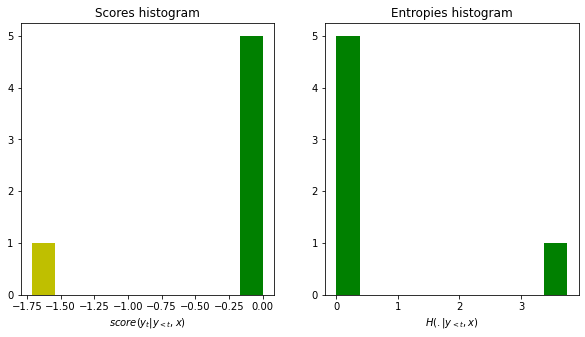

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Which novelist and playwright is commemorated by the Rodin sculpture which stands in the Boulevard Raspail in Paris?
Expected answer: BALZAC
Answer:  Honoré de Balzac</s>

----------  ------  --------  --------  --------  ---------  --------
             Honor  é          de        Bal      zac        </s>
max(score)  -0.742  -0.00105  -0.00577  -0.00293  -0.000115  -0.00772
----------  ------  --------  --------  --------  ---------  --------
             Honor  é          de        Bal      zac        </s>
H(scores)   3.73    0.0107    0.052     0.0327    0.00138    0.0593
----------  ------  --------  --------  --------  ---------  --------


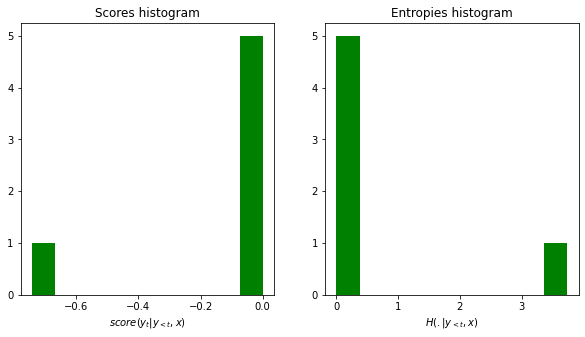

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: "Founded in 1897, which animal welfare charity was formerly known As ""Our Dumb Friends League""?"
Expected answer: Blue Cross
Answer:  Dogs Trust</s>

----------  -----  ------  --------  -------
             Dog   s        Trust    </s>
max(score)  -1.52  -0.126  -0.00273  -0.0197
----------  -----  ------  --------  -------
             Dog   s        Trust    </s>
H(scores)   3.33   0.418   0.0254    0.178
----------  -----  ------  --------  -------


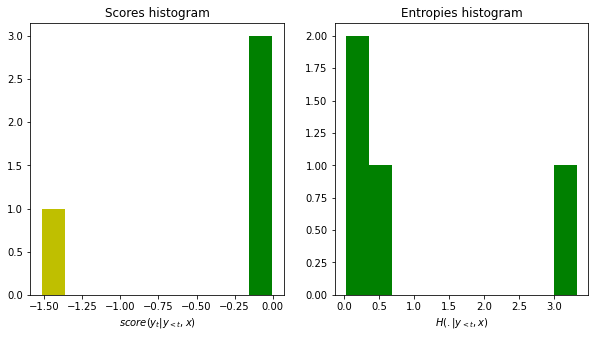

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: "Founded in 1897, which animal welfare charity was formerly known As ""Our Dumb Friends League""?"
Expected answer: Blue Cross
Answer:  Dogs Trust</s>

----------  -----  ------  --------  -------
             Dog   s        Trust    </s>
max(score)  -1.52  -0.126  -0.00273  -0.0197
----------  -----  ------  --------  -------
             Dog   s        Trust    </s>
H(scores)   3.33   0.418   0.0254    0.178
----------  -----  ------  --------  -------


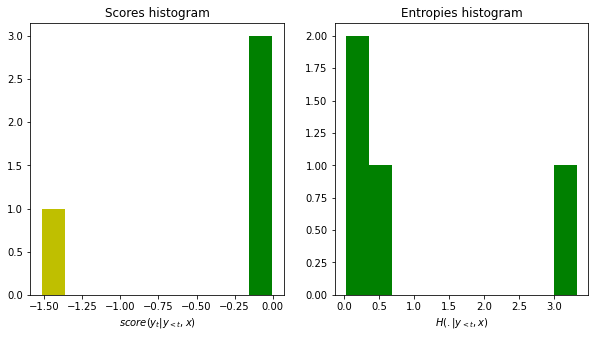

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: What product do Trappist monks in Belgium and the Netherlands famously sell?
Expected answer: Beer
Answer:  beer</s>

----------  ------  -------
             beer   </s>
max(score)  -0.316  -0.0486
----------  ------  -------
             beer   </s>
H(scores)   1.56    0.291
----------  ------  -------


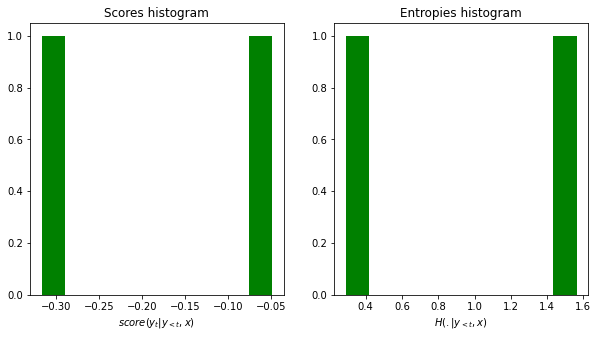

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: What product do Trappist monks in Belgium and the Netherlands famously sell?
Expected answer: Beer
Answer:  beer</s>

----------  ------  -------
             beer   </s>
max(score)  -0.338  -0.0535
----------  ------  -------
             beer   </s>
H(scores)   1.64    0.316
----------  ------  -------


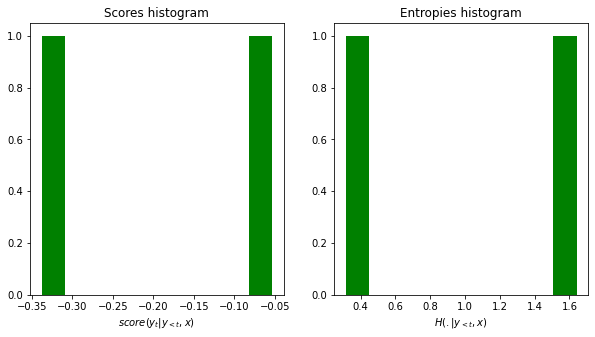

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: In which country was Alexander Dubcek First Secretary of the Communist Party in 1968-1969?
Expected answer: CZECHOSLOVAKIA
Answer:  Czechoslovakia</s>

----------  -------  -------  -------  ------  --------
             Cz      echos    lov      akia    </s>
max(score)  -0.0708  -0.0228  -0.0664  -0.217  -0.00209
----------  -------  -------  -------  ------  --------
             Cz      echos    lov      akia    </s>
H(scores)   0.395    0.147    0.342    0.703   0.0201
----------  -------  -------  -------  ------  --------


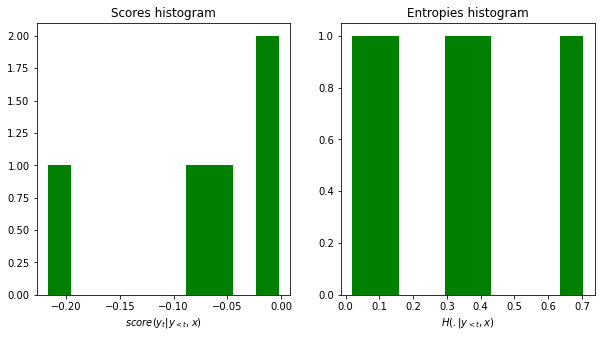

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: In which country was Alexander Dubcek First Secretary of the Communist Party in 1968-1969?
Expected answer: CZECHOSLOVAKIA
Answer:  Czechoslovakia</s>

----------  -------  -------  -------  ------  --------
             Cz      echos    lov      akia    </s>
max(score)  -0.0635  -0.0227  -0.0588  -0.213  -0.00197
----------  -------  -------  -------  ------  --------
             Cz      echos    lov      akia    </s>
H(scores)   0.359    0.146    0.312    0.676   0.0189
----------  -------  -------  -------  ------  --------


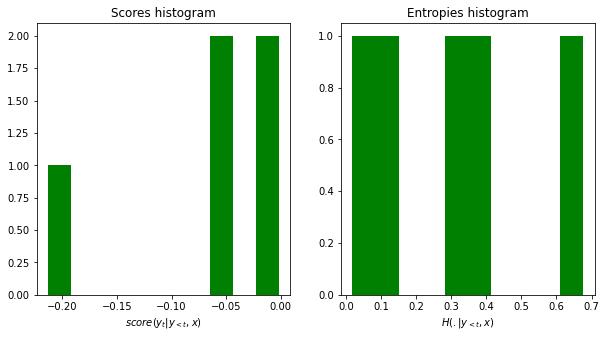

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: In which English County is RAF Scampton home of the Red Arrows?
Expected answer: LINCOLNSHIRE
Answer:  Lincolnshire</s>

----------  --------  -------  -------
             Lincoln  shire    </s>
max(score)  -0.494    -0.0118  -0.0933
----------  --------  -------  -------
             Lincoln  shire    </s>
H(scores)   2.25      0.0737   0.383
----------  --------  -------  -------


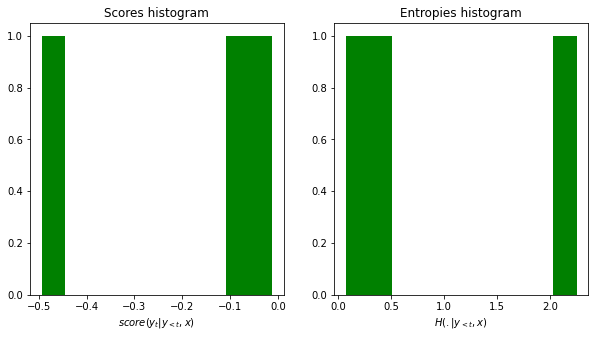

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: In which English County is RAF Scampton home of the Red Arrows?
Expected answer: LINCOLNSHIRE
Answer:  Lincolnshire</s>

----------  --------  --------  -------
             Lincoln  shire     </s>
max(score)  -0.482    -0.00601  -0.0796
----------  --------  --------  -------
             Lincoln  shire     </s>
H(scores)   2.33      0.0413    0.332
----------  --------  --------  -------


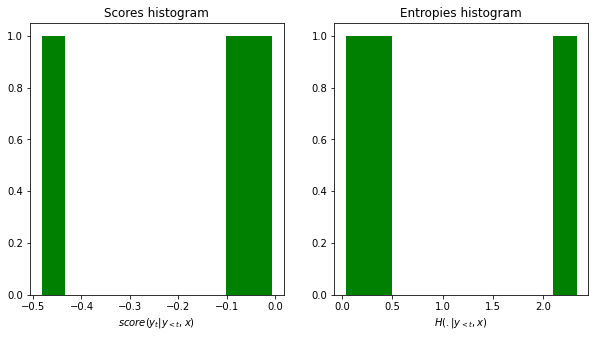

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Don't Rain on My Parade and Second Hand Rose are songs from which musical?
Expected answer: Funny Girl
Answer:  Carousel</s>

----------  -----  ---------  -------
             Car   ousel      </s>
max(score)  -2.98  -9.54e-06  -0.0146
----------  -----  ---------  -------
             Car   ousel      </s>
H(scores)   5.62   0.000145   0.121
----------  -----  ---------  -------


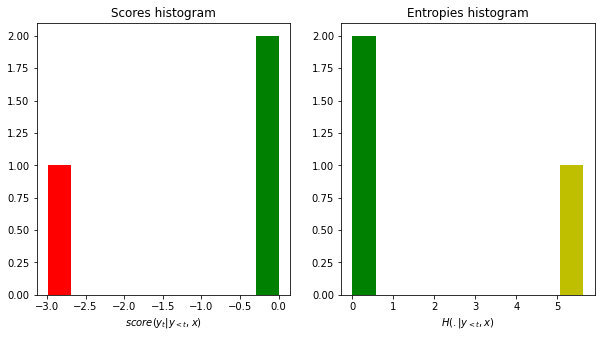

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Don't Rain on My Parade and Second Hand Rose are songs from which musical?
Expected answer: Funny Girl
Answer:  Hair</s>

----------  -----  ------
             Hair  </s>
max(score)  -2.06  -0.022
----------  -----  ------
             Hair  </s>
H(scores)   5.69   0.224
----------  -----  ------


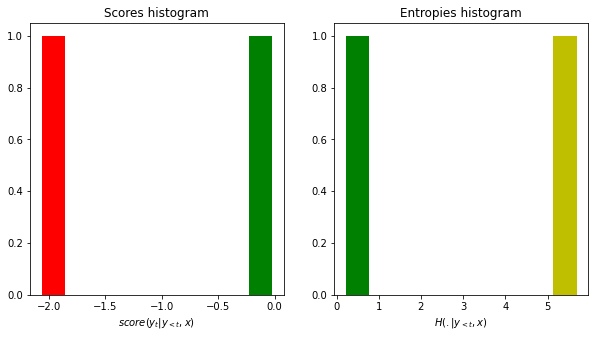

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Danny and Sandy are the main characters in which musical?
Expected answer: Grease
Answer:  Grease</s>

----------  ------  --------  -------
             Gre    ase       </s>
max(score)  -0.996  -0.00244  -0.0294
----------  ------  --------  -------
             Gre    ase       </s>
H(scores)   3.89    0.0234    0.283
----------  ------  --------  -------


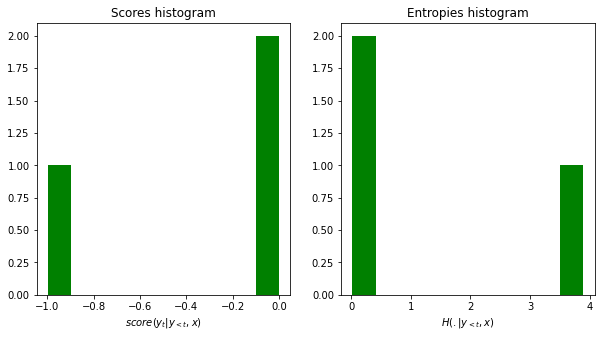

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Danny and Sandy are the main characters in which musical?
Expected answer: Grease
Answer:  Grease</s>

----------  ------  --------  -------
             Gre    ase       </s>
max(score)  -0.188  -0.00244  -0.0294
----------  ------  --------  -------
             Gre    ase       </s>
H(scores)   3.95    0.0234    0.283
----------  ------  --------  -------


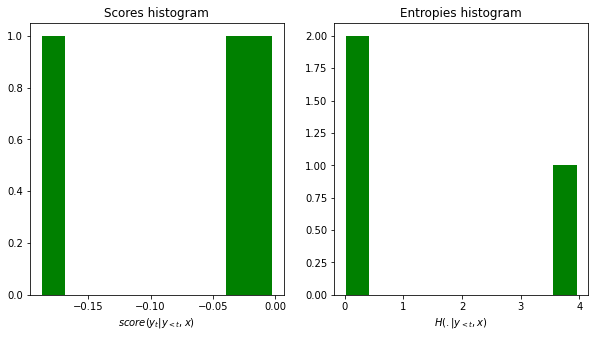

In [ ]:
np.random.seed(42)
triviaqa_cpmi_results = defaultdict(list)
for i in np.random.choice(np.arange(len(triviaqa_samples)), 30):
    sample = triviaqa_samples[i]
    text_query = sample.gen_model_input()
    for lambd, tau in [
        (0, 0), # usual greedy inference, without marginal term
        (0.0656, 3.599),  # optimal parameters for BARTS2S as in the paper
    ]:
        triviaqa_cpmi_results[lambd, tau].append((
            sample,
            experiment(model, tokenizer, text_query, sample.answer, lambd, tau)))

### WMT ru-en dataset

In [ ]:
class WMTSample:
    def __init__(self, s, base_lang):
        assert base_lang in ['ru', 'en']
        self.translate_to = 'Russian' if base_lang == 'en' else 'English'
        if base_lang == 'ru':
            self.inp_text = s['translation']['ru']
            self.answer = s['translation']['en']
        elif base_lang == 'en':
            self.inp_text = s['translation']['en']
            self.answer = s['translation']['ru']
    
    def gen_model_input(self):
        return 'Translate to {}: {}'.format(self.translate_to, self.inp_text)

    def gen_p_true_question(self, proposed_answer):
        return 'Task: Translate to {} "{}"\n\nProposed Answer: "{}"\n\nIs the proposed answer True or False?'\
            .format(self.translate_to, self.inp_text, proposed_answer)

raw = load_dataset("wmt16", 'ru-en', split='test')
wmt_samples = [WMTSample(s, base_lang) for s in raw for base_lang in ['ru', 'en']]
print(wmt_samples[0].gen_model_input())
print(wmt_samples[0].answer)

Mar 26 17:48:18.794 [WARN] [datasets.builder.download_and_prepare:798] Found cached dataset wmt16 (/root/.cache/huggingface/datasets/wmt16/ru-en/1.0.0/746749a11d25c02058042da7502d973ff410e73457f3d305fc1177dc0e8c4227)


Translate to English: Социальная карта жителя Ивановской области признается электронным средством платежа.
The social card of residents of Ivanovo region is to be recognised as an electronic payment instrument.


Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: "Я не могу отделаться от мысли, что BBC готовит к запуску и транслирует передачи, которые могли бы показывать конкурирующие компании, не получающие субсидий", - рассказал Джонсон членам Комитета по коммуникациям Палаты лордов в рамках выяснения дальнейшей судьбы BBC.
Expected answer: "I do struggle with the idea that the BBC commissions and broadcasts programmes that would clearly be shown by unsubsidised rivals," Johnson told the House of Lords communication committee, as part of its inquiry into the future of the BBC.
Answer: </s>

----------  ------
            </s>
max(score)  -0.938
----------  ------
            </s>
H(scores)   2.03
----------  ------


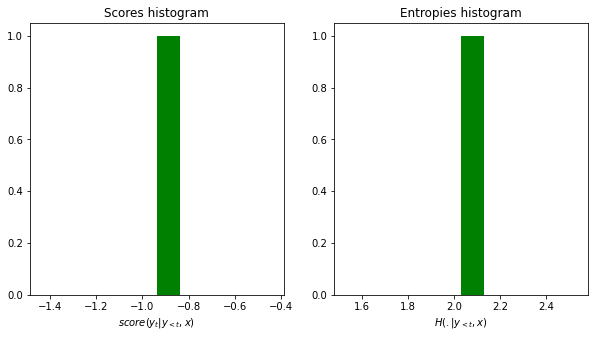

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: "Я не могу отделаться от мысли, что BBC готовит к запуску и транслирует передачи, которые могли бы показывать конкурирующие компании, не получающие субсидий", - рассказал Джонсон членам Комитета по коммуникациям Палаты лордов в рамках выяснения дальнейшей судьбы BBC.
Expected answer: "I do struggle with the idea that the BBC commissions and broadcasts programmes that would clearly be shown by unsubsidised rivals," Johnson told the House of Lords communication committee, as part of its inquiry into the future of the BBC.
Answer: </s>

----------  ------
            </s>
max(score)  -0.938
----------  ------
            </s>
H(scores)   2.03
----------  ------


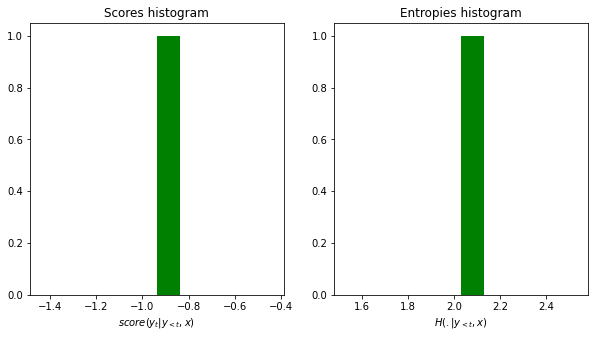

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Компания заявила, что по-прежнему планирует рост выручки по сравнению с прошлым годом благодаря сокращению расходов, повышению валового дохода и росту онлайн-торговли.
Expected answer: The company said it still expects earnings to grow over the previous year because of cost-cutting, higher revenue and growth in online commerce.
Answer:  The company said it is still planning to grow its revenue this year compared to last year, thanks to cost-cutting, higher advertising revenue, and growing online trading.</s>

----------  ----  --------  ------  ------  -----  ------  ---------  ------  ------  -----  --------  -----  --------  ---------  ------  ------  ------  ------  -------  ------  ------  ------  --------  ------  -------  ------------  --------  ------  ---------  --------  -------  --------  -------  ---------
             The   company   said    it      is     still   planning   to      grow    its    revenue   this   year      compared   to      la

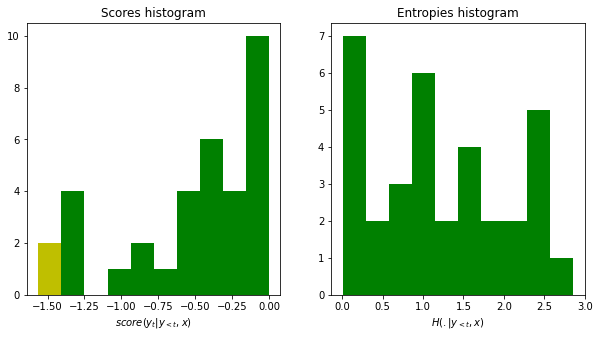

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Компания заявила, что по-прежнему планирует рост выручки по сравнению с прошлым годом благодаря сокращению расходов, повышению валового дохода и росту онлайн-торговли.
Expected answer: The company said it still expects earnings to grow over the previous year because of cost-cutting, higher revenue and growth in online commerce.
Answer:  The company said it is still planning to grow revenues this year compared to last year, thanks to cost-cutting, higher advertising revenue, and growth in online trading.</s>

----------  ------  --------  ------  ------  -----  ------  ---------  ------  -----  ---------  ------  -------  ---------  ------  ------  ------  -----  -------  -------  ------  ------  -------  ------  -------  ------------  --------  ------  ---------  -------  -------  -------  --------  -------  ---------
             The     company   said    it      is     still   planning   to      grow   revenues   this    year     compared   to      last  

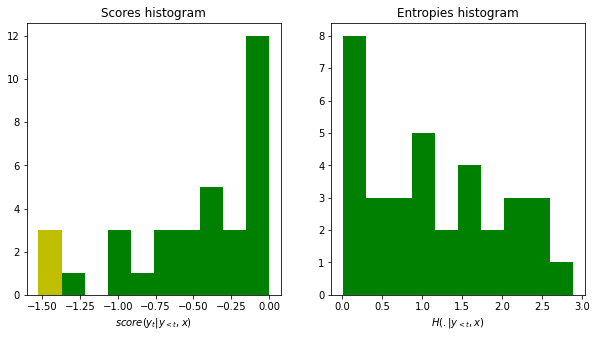

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: В текущем году исследование Ассоциации российских менеджеров "Топ-1000 российских менеджеров" выходит в 16-й раз.
Expected answer: This year, the Association of Russian Managers' study, "Top 1000 Russian Managers", will be published for the 16th time.
Answer: </s>

----------  ------
            </s>
max(score)  -0.918
----------  ------
            </s>
H(scores)   1.99
----------  ------


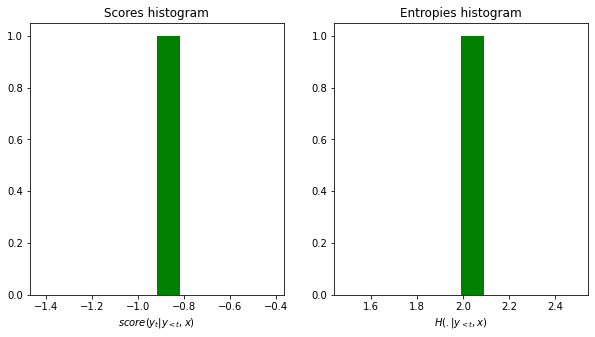

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: В текущем году исследование Ассоциации российских менеджеров "Топ-1000 российских менеджеров" выходит в 16-й раз.
Expected answer: This year, the Association of Russian Managers' study, "Top 1000 Russian Managers", will be published for the 16th time.
Answer: </s>

----------  ------
            </s>
max(score)  -0.938
----------  ------
            </s>
H(scores)   1.99
----------  ------


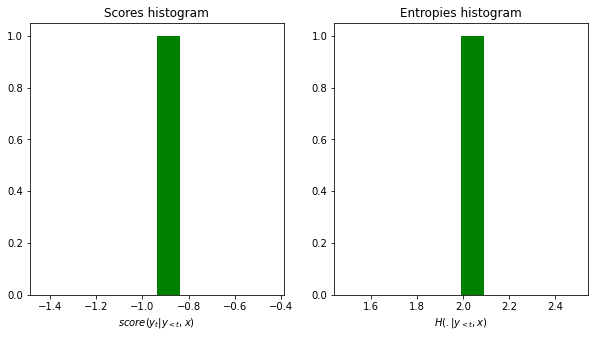

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Сначала они хотели 17% индексации, теперь они хотят 10%, а еще и многомиллиардные субсидии из бюджета, - говорит он. -
Expected answer: At first they wanted a 17% indexing, and now they want 10%, in addition to multi-billion rouble subsidies from the budget, he said.
Answer:  First they wanted 17%, now they want 10%, and they want to take billions from the budget, he says.</s>

----------  ------  ------  -------  ------  ------  ------  -----  ------  -------  -----  ------  -----  ------  -----  -----  ---------  ------  -------  -------  ------  -----  ------  --------  --------
             First   they    wanted   17%    ,        now     they   want    10%     ,       and     they   want    to     take   billions   from    the      budget  ,        he     says   .         </s>
max(score)  -0.574  -0.318  -0.194   -0.535  -0.996  -0.447  -0.73  -0.133  -0.0342  -0.43  -0.229  -1.84  -0.887  -1.54  -2.16  -1.98      -0.484  -0.0157  -0.0737  -0.598  -0.4

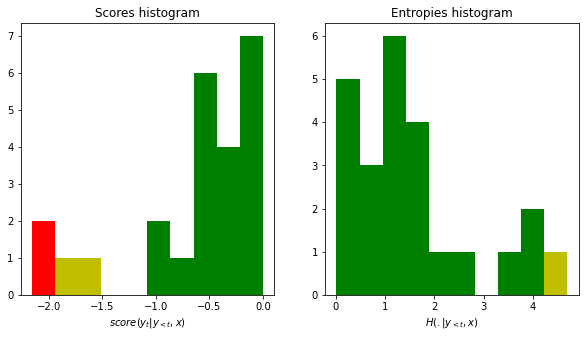

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Сначала они хотели 17% индексации, теперь они хотят 10%, а еще и многомиллиардные субсидии из бюджета, - говорит он. -
Expected answer: At first they wanted a 17% indexing, and now they want 10%, in addition to multi-billion rouble subsidies from the budget, he said.
Answer:  First they wanted 17%, now they want 10%, and they want even more subtractions from the budget, he says.</s>

----------  ------  ------  -------  ------  ------  ------  -----  ------  -------  -----  ------  -----  ------  -----  -----  -----  ------  ---------  -------  -------  -------  ------  ------  ------  --------  --------
             First   they    wanted   17%    ,        now     they   want    10%     ,       and     they   want    even   more   sub   tr      actions     from     the      budget  ,        he      says   .         </s>
max(score)  -0.574  -0.318  -0.194   -0.535  -0.996  -0.447  -0.73  -0.133  -0.0342  -0.43  -0.229  -1.84  -0.887  -1.38  -0.68  -1.73  -0

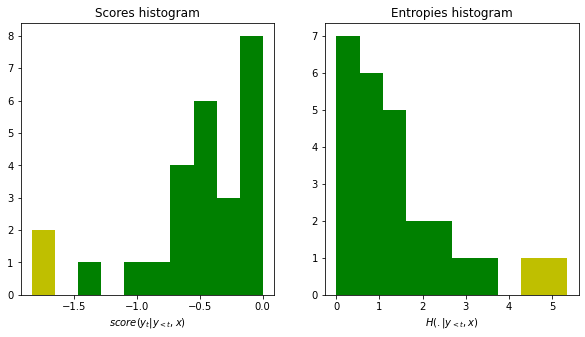

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Прессинг, которому я подвергаюсь, настолько сильный, что даже я, видавший виды паренек, думаю, что люди белены объелись.
Expected answer: The pressure that I have been dealing with is so strong that even a person like me, who has been around the block more than a few times, thinks that people have gone crazy.
Answer:  The persecution I suffer is so severe that even though I am a type of pariah, I think that the Jews are to blame.</s>

----------  -----  ------  -------  ------  -------  -------  -------  -------  ------  ------  -------  ------  ------  ------  -----  -------  -----  ------  ------  -------  ------  -----  -----  -----  -----  ------  -------  -------  ------
             The    pers   ecution   I       suffer   is       so       severe   that    even    though   I       am      a       type   of       par   iah     ,        I        think   that   the    Jews   are    to      blame   .        </s>
max(score)  -1.16  -0.539  -0.0146  -0.926

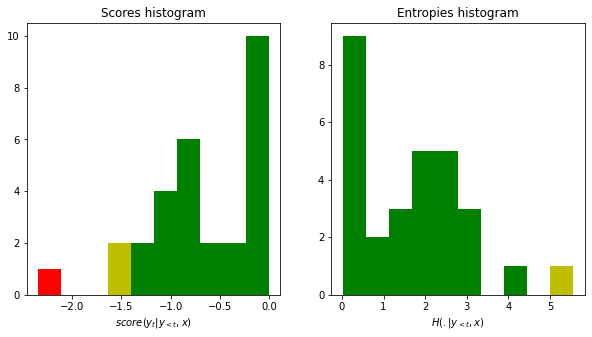

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Прессинг, которому я подвергаюсь, настолько сильный, что даже я, видавший виды паренек, думаю, что люди белены объелись.
Expected answer: The pressure that I have been dealing with is so strong that even a person like me, who has been around the block more than a few times, thinks that people have gone crazy.
Answer:  The persecution I am suffering is so severe that even though I am a type of pariah, I think that the Jews are to blame.</s>

----------  -----  ------  -------  ------  -----  ----------  -------  -------  -------  -------  ------  -------  ------  ------  ------  -----  -------  -----  ------  ------  -------  ------  -----  ------  -----  -----  -----  -------  -------  --------
             The    pers   ecution   I       am     suffering   is       so       severe   that     even    though   I       am      a       type   of       par   iah     ,        I        think   that   the     Jews   are    to     blame   .        </s>
max(score)  

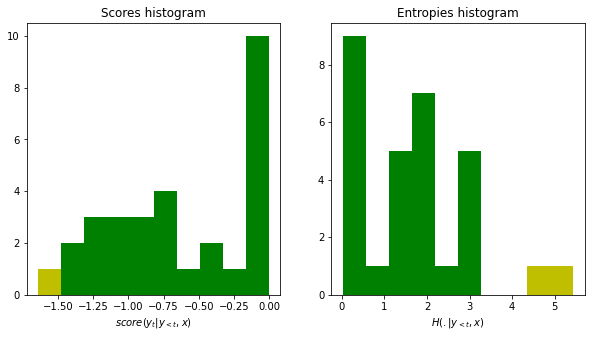

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Уровень безработицы в Шотландии, 5,9%, был выше уровня по Соединенному Королевству в 5,5%, как показали цифры Службы национальной статистики (ONS).
Expected answer: Scotland's unemployment rate of 5.9 per cent was above the UK's rate of 5.5 per cent, the Office for National Statistics (ONS) figures showed.
Answer: </s>

----------  -----
            </s>
max(score)  -0.23
----------  -----
            </s>
H(scores)   0.957
----------  -----


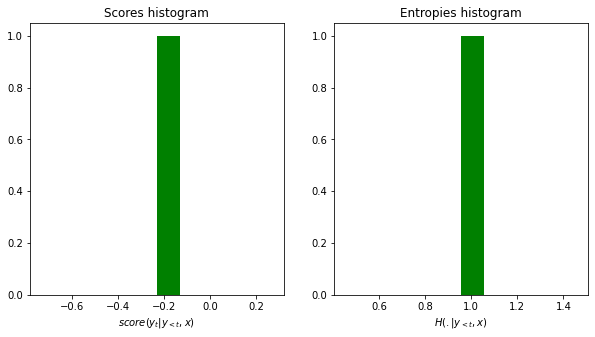

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Уровень безработицы в Шотландии, 5,9%, был выше уровня по Соединенному Королевству в 5,5%, как показали цифры Службы национальной статистики (ONS).
Expected answer: Scotland's unemployment rate of 5.9 per cent was above the UK's rate of 5.5 per cent, the Office for National Statistics (ONS) figures showed.
Answer: </s>

----------  -----
            </s>
max(score)  -0.23
----------  -----
            </s>
H(scores)   0.957
----------  -----


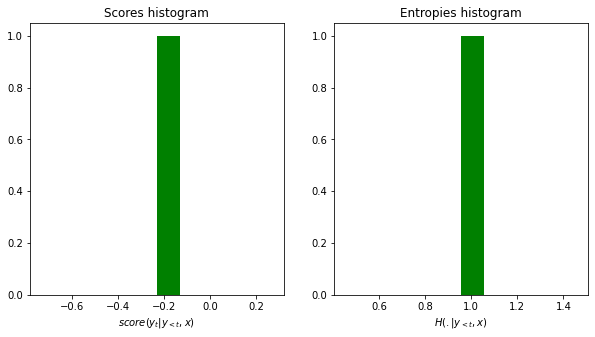

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Интересно, что Джонс считает, что рынки уже адаптировались к ожидаемым результатам политики Федеральной системы.
Expected answer: Interestingly, Jones thinks markets already have adapted to Fed policy expectations.
Answer: </s>

----------  ------
            </s>
max(score)  -0.832
----------  ------
            </s>
H(scores)   2.12
----------  ------


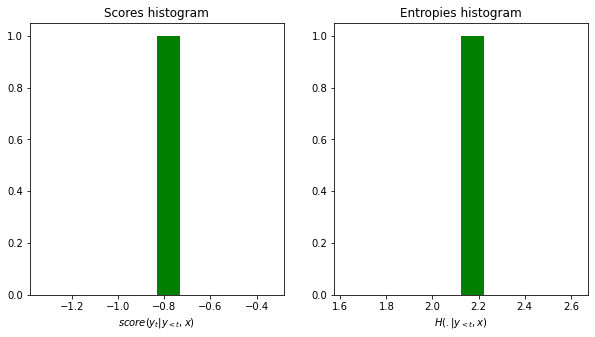

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Интересно, что Джонс считает, что рынки уже адаптировались к ожидаемым результатам политики Федеральной системы.
Expected answer: Interestingly, Jones thinks markets already have adapted to Fed policy expectations.
Answer: </s>

----------  ------
            </s>
max(score)  -0.828
----------  ------
            </s>
H(scores)   2.12
----------  ------


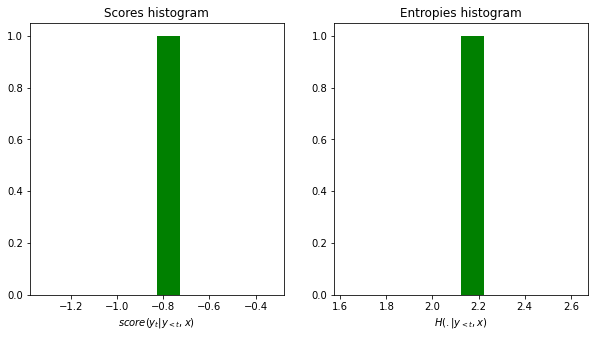

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Ранее сегодня заместитель начальника Генштаба ВС России Николай Богдановский сообщил, что Генштаб не исключает возможности создания в будущем базы ВВС в Сирии.
Expected answer: Earlier today, the Deputy Chief of the General Staff of the Russian Armed Forces, Nikolai Bogdanovsky, reported that the General Staff has not ruled out the possibility of establishing an air force base in Syria in the future.
Answer: </s>

----------  ------
            </s>
max(score)  -0.699
----------  ------
            </s>
H(scores)   2.23
----------  ------


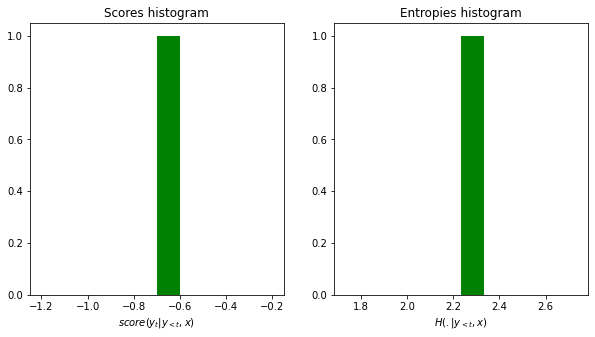

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Ранее сегодня заместитель начальника Генштаба ВС России Николай Богдановский сообщил, что Генштаб не исключает возможности создания в будущем базы ВВС в Сирии.
Expected answer: Earlier today, the Deputy Chief of the General Staff of the Russian Armed Forces, Nikolai Bogdanovsky, reported that the General Staff has not ruled out the possibility of establishing an air force base in Syria in the future.
Answer: </s>

----------  ------
            </s>
max(score)  -0.645
----------  ------
            </s>
H(scores)   2.14
----------  ------


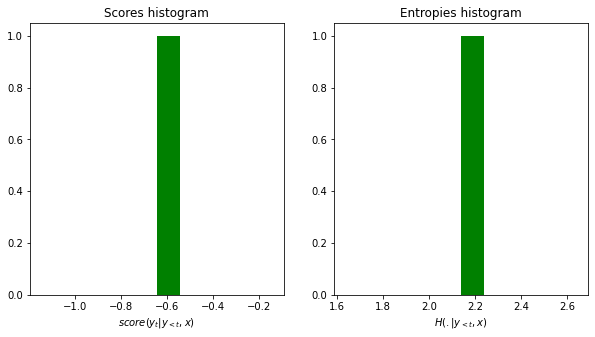

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Министр иностранных дел Сербии объявил "неприемлемой" высылку мигрантов назад из Венгрии, когда их все больше и больше прибывает из Македонии и Греции.
Expected answer: Serbia's foreign minister declared it was "unacceptable" that migrants were being sent back from Hungary while more and more were arriving from Macedonia and Greece.
Answer:  The Minister of Foreign Affairs of the Republic of Serbia announced the "unsatisfactory" emigration of migrants from Hungary, as more and more migrants are coming from Macedonia and Greece.</s>

----------  -----  ---------  ------  --------  --------  -------  ------  ---------  --------  -------  ----------  -----  -----  -----  ------  ---------  -------  -----  --------  ------  ---------  ------  --------  ------  -----  -----  -------  ---------  ---------  -----  -------  -------  ----------  -------  --------  -------  --------
             The    Minister   of      Foreign   Affairs   of       the     Republic 

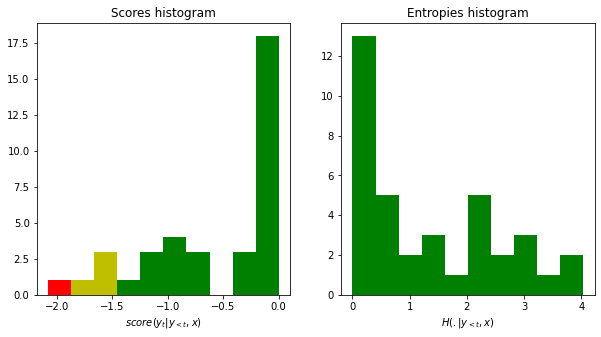

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Министр иностранных дел Сербии объявил "неприемлемой" высылку мигрантов назад из Венгрии, когда их все больше и больше прибывает из Македонии и Греции.
Expected answer: Serbia's foreign minister declared it was "unacceptable" that migrants were being sent back from Hungary while more and more were arriving from Macedonia and Greece.
Answer:  The Minister of Foreign Affairs of the Republic of Serbia announced that the sending of migrants back from Germany is "not acceptable", as more and more migrants are coming from Macedonia and Greece.</s>

----------  -----  ---------  ------  --------  --------  -------  ------  ---------  -------  -------  ----------  -----  ------  --------  ------  ---------  ------  ------  --------  ------  ------  -----------  ------  ------  ------  ------  -------  ---------  ---------  ------  -------  ------  ----------  --------  --------  -------  ---------
             The    Minister   of      Foreign   Affairs   of       

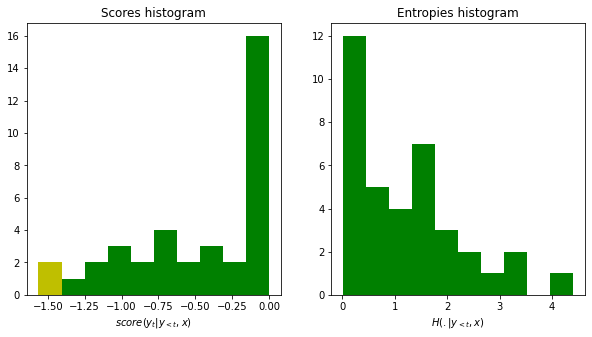

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Ответ на обращение жителя Новосибирска поступит в течение 30 дней.
Expected answer: A decision on the Novosibirsk resident's request will be issued within 30 days.
Answer:  The response to the appeal of the citizen of Novosibirsk will be sent within 30 days.</s>

----------  ------  ---------  ------  ------  -------  ------  ------  --------  -------  ------  ---------  ---------  ---------  ------  ------  ------  -------  -------  -------  -------  ---------
             The     response   to      the     appeal   of      the     citizen   of       Novos  ib         irs        k           will    be      sent    within  30        days    .        </s>
max(score)  -0.551  -0.773     -0.185  -0.175  -1.58    -0.224  -0.154  -0.82     -0.0152  -0.24   -0.000326  -0.000885  -0.000877  -0.137  -0.389  -0.953  -0.104   -0.0525  -0.0065  -0.0062  -0.000136
----------  ------  ---------  ------  ------  -------  ------  ------  --------  -------  ------  -------

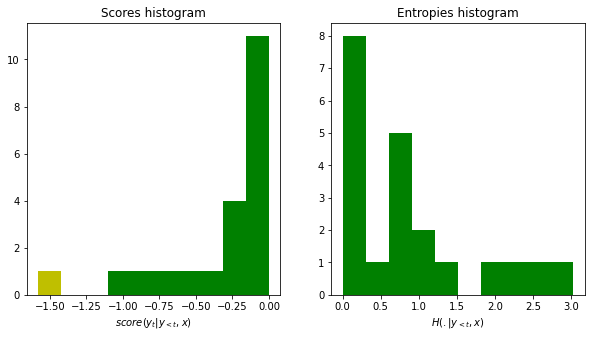

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Ответ на обращение жителя Новосибирска поступит в течение 30 дней.
Expected answer: A decision on the Novosibirsk resident's request will be issued within 30 days.
Answer:  The response to the appeal of the citizen of Novosibirsk will be sent within 30 days.</s>

----------  ------  ---------  ------  ------  -------  ------  ------  --------  -------  ------  ---------  ---------  ---------  ------  ------  ------  -------  -------  -------  -------  ---------
             The     response   to      the     appeal   of      the     citizen   of       Novos  ib         irs        k           will    be      sent    within  30        days    .        </s>
max(score)  -0.551  -0.773     -0.185  -0.175  -1.58    -0.224  -0.154  -0.82     -0.0152  -0.24   -0.000326  -0.000885  -0.000877  -0.137  -0.389  -0.953  -0.104   -0.0525  -0.0065  -0.0062  -0.000136
----------  ------  ---------  ------  ------  -------  ------  ------  --------  -------  ------  -------

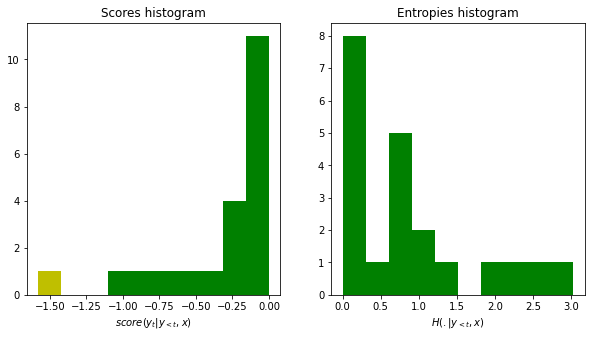

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: "Я все изменю", - заявил Дейла
Expected answer: I'll turn things around, vows Deila
Answer: . "I'll change everything", said Dalia.</s>

----------  ------  ------  ------  -------  -----------  ------  ------  ------  ------  -----  --------  ---------
            .        "I     'll      change   everything  "       ,        said    D      alia   .         </s>
max(score)  -0.199  -0.359  -0.379  -0.0703  -0.136       -0.867  -0.266  -0.566  -0.367  -1.54  -0.00366  -0.000404
----------  ------  ------  ------  -------  -----------  ------  ------  ------  ------  -----  --------  ---------
            .        "I     'll      change   everything  "       ,        said    D      alia   .         </s>
H(scores)   1.23    1.28    0.789   0.43     0.57         1.13    1.03    2.19    1.66    2.48   0.0308    0.00458
----------  ------  ------  ------  -------  -----------  ------  ------  ------  ------  -----  --------  ---------


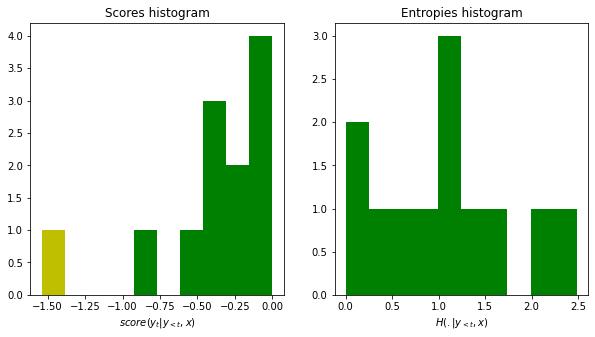

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: "Я все изменю", - заявил Дейла
Expected answer: I'll turn things around, vows Deila
Answer: . "I'll change everything", said Dalia.</s>

----------  ------  ------  ------  -------  -----------  ------  ------  ------  ------  -----  --------  ---------
            .        "I     'll      change   everything  "       ,        said    D      alia   .         </s>
max(score)  -0.199  -0.359  -0.379  -0.0703  -0.136       -0.867  -0.266  -0.566  -0.367  -1.54  -0.00366  -0.000404
----------  ------  ------  ------  -------  -----------  ------  ------  ------  ------  -----  --------  ---------
            .        "I     'll      change   everything  "       ,        said    D      alia   .         </s>
H(scores)   1.23    1.28    0.789   0.43     0.57         1.13    1.03    2.19    1.66    2.48   0.0308    0.00458
----------  ------  ------  ------  -------  -----------  ------  ------  ------  ------  -----  --------  ---------


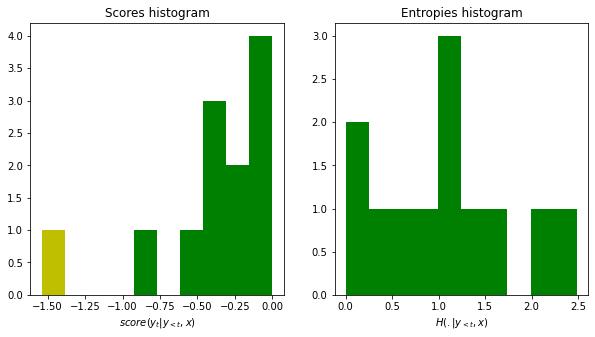

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Однако невыполнимые дедлайны имеют и положительную сторону: по крайней мере, они заставляют ответственных лиц шевелиться.
Expected answer: However, impossible deadlines have an upside: at least they force the responsible parties to get cracking.
Answer: </s>

----------  ------
            </s>
max(score)  -0.574
----------  ------
            </s>
H(scores)   1.72
----------  ------


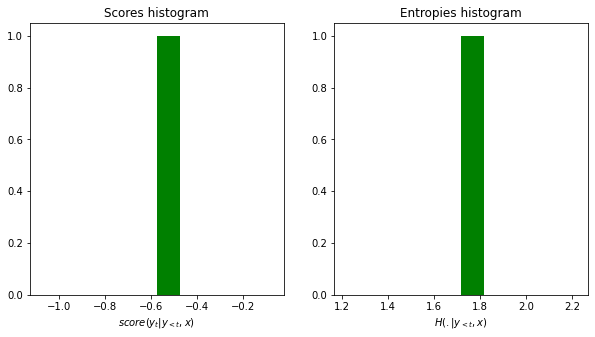

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Однако невыполнимые дедлайны имеют и положительную сторону: по крайней мере, они заставляют ответственных лиц шевелиться.
Expected answer: However, impossible deadlines have an upside: at least they force the responsible parties to get cracking.
Answer: </s>

----------  ------
            </s>
max(score)  -0.574
----------  ------
            </s>
H(scores)   1.72
----------  ------


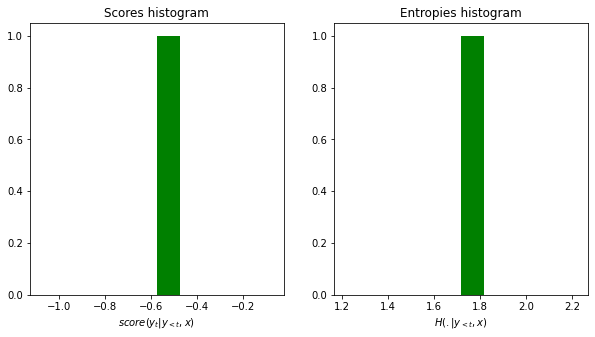

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Большинство республиканцев не считают темперамент Трампа проблемой.
Expected answer: A majority of Republicans don't see Trump's temperament as a problem.
Answer:  Most of the republic's residents do not consider the temperature of the tap water a problem.</s>

----------  ------  ----  -------  ---------  -----  ----------  -----  --------  ---------  -----  ------------  ----  ------  -----  -------  ------  --------  --------  ---------
             Most    of    the      republic  's      residents   do     not       consider   the    temperature   of    the     tap    water    a       problem  .         </s>
max(score)  -0.279  -1.2  -0.0347  -0.625     -1.02  -0.945      -0.77  -0.00244  -0.373     -0.35  -0.676        -1.6  -0.973  -1.83  -0.0752  -0.459  -0.0156   -0.00638  -0.000198
----------  ------  ----  -------  ---------  -----  ----------  -----  --------  ---------  -----  ------------  ----  ------  -----  -------  ------  --------  ------

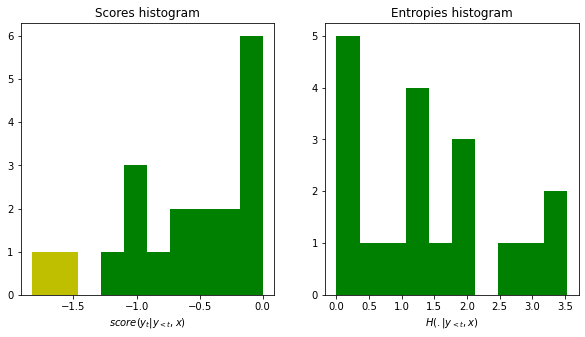

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Большинство республиканцев не считают темперамент Трампа проблемой.
Expected answer: A majority of Republicans don't see Trump's temperament as a problem.
Answer:  Most of the republic's residents do not consider the temperature of the tap water a problem.</s>

----------  ------  ----  -------  ---------  -----  ----------  -----  --------  ---------  -----  ------------  ----  ------  -----  -------  ------  --------  --------  ---------
             Most    of    the      republic  's      residents   do     not       consider   the    temperature   of    the     tap    water    a       problem  .         </s>
max(score)  -0.279  -1.2  -0.0347  -0.625     -1.02  -0.945      -0.77  -0.00244  -0.373     -0.35  -0.676        -1.6  -0.973  -1.83  -0.0752  -0.459  -0.0156   -0.00638  -0.000198
----------  ------  ----  -------  ---------  -----  ----------  -----  --------  ---------  -----  ------------  ----  ------  -----  -------  ------  --------  ------

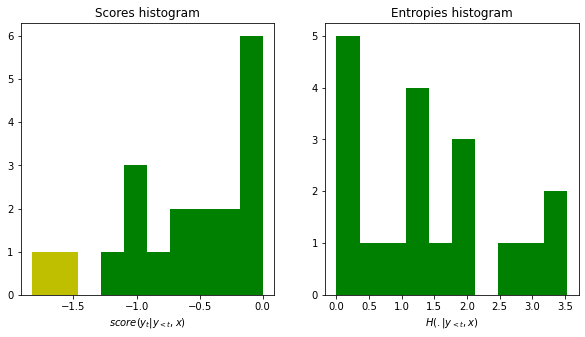

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Chase Australia - замена Million Dollar Minute, которое не смогло переиграть шоу Мак-Гвайра.
Expected answer: The Chase Australia is a replacement for Million Dollar Minute which failed to dent McGuire's show.
Answer: </s>

----------  ------
            </s>
max(score)  -0.125
----------  ------
            </s>
H(scores)   1.03
----------  ------


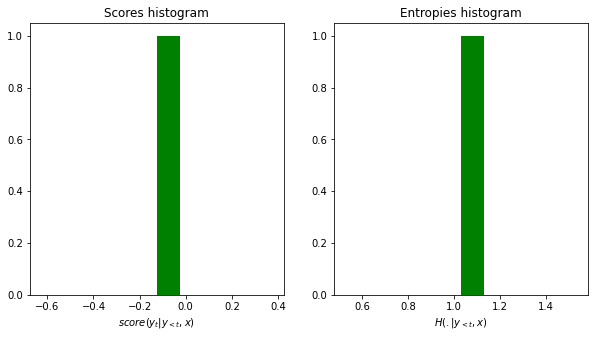

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Chase Australia - замена Million Dollar Minute, которое не смогло переиграть шоу Мак-Гвайра.
Expected answer: The Chase Australia is a replacement for Million Dollar Minute which failed to dent McGuire's show.
Answer: </s>

----------  ------
            </s>
max(score)  -0.163
----------  ------
            </s>
H(scores)   1.25
----------  ------


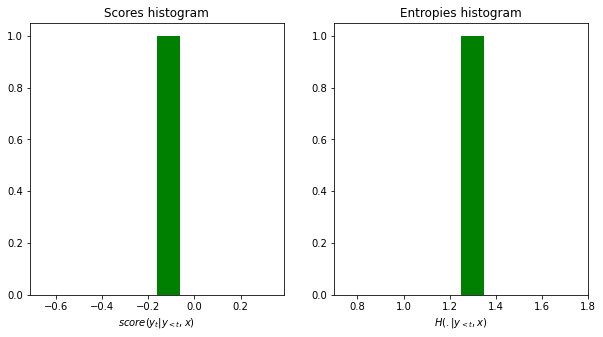

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Появляется Алекс Хэйлс, и он бэтсман, которого я оцениваю высоко.
Expected answer: Alex Hales comes in and he is a batsman I rate highly.
Answer:  Alex Haley appears, and he is the best man I have ever known.</s>

----------  ------  -----  ------  --------  ------  -------  ------  -------  ------  -----  ------  ------  ------  -------  ------  -------  --------
             Alex    Hale  y        appears  ,        and      he      is       the     best   man     I       have    ever     known  .        </s>
max(score)  -0.249  -0.77  -0.177  -0.879    -0.492  -0.0332  -0.805  -0.0294  -0.766  -1.69  -0.609  -0.746  -0.512  -0.0339  -0.969  -0.0102  -0.00111
----------  ------  -----  ------  --------  ------  -------  ------  -------  ------  -----  ------  ------  ------  -------  ------  -------  --------
             Alex    Hale  y        appears  ,        and      he      is       the     best   man     I       have    ever     known  .        </s>


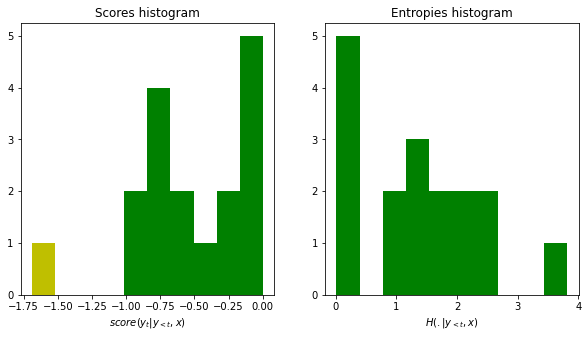

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Появляется Алекс Хэйлс, и он бэтсман, которого я оцениваю высоко.
Expected answer: Alex Hales comes in and he is a batsman I rate highly.
Answer:  Alex Haley appears, and he is the best man I have ever known.</s>

----------  ------  -----  ------  --------  ------  -------  ------  -------  ------  -----  ------  ------  ------  -------  ------  -------  --------
             Alex    Hale  y        appears  ,        and      he      is       the     best   man     I       have    ever     known  .        </s>
max(score)  -0.249  -0.77  -0.177  -0.879    -0.492  -0.0332  -0.805  -0.0294  -0.758  -1.27  -0.602  -0.703  -0.523  -0.0332  -0.992  -0.0097  -0.00121
----------  ------  -----  ------  --------  ------  -------  ------  -------  ------  -----  ------  ------  ------  -------  ------  -------  --------
             Alex    Hale  y        appears  ,        and      he      is       the     best   man     I       have    ever     known  .        </s>


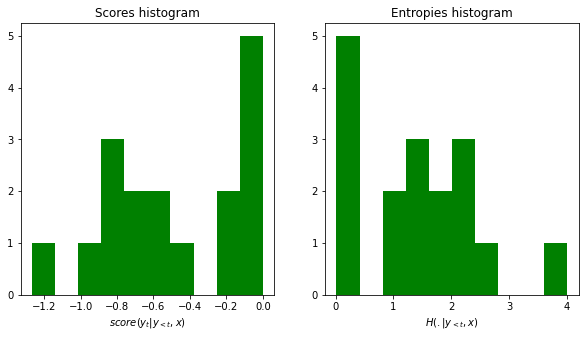

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Я не эксперт по вратарям, я сам вратарь, у нас не показывают повторы пропущенных голов, поэтому сложно отследить.
Expected answer: I'm not an expert on goalies: I'm a goalie myself; they don't show us the replays of conceded goals, and so it's difficult to keep track.
Answer:  I'm not an expert on robots, I'm a robot, we don't show rewinds of missed heads, so it's hard to track.</s>

----------  -----  -----  ------  -------  ------  -------  -----  ------  ------  -------  ------  ------  -------  ------  -----  -----  -----  ------  -------  ------  ------  ------  ------  ------  -------  ------  ------  ---------
             I'm    not    an      expert   on      robots  ,       I'm     a       robot   ,        we      don't    show    re    wind   s       of      missed   heads  ,        so      it's    hard    to       track  .       </s>
max(score)  -0.84  -0.24  -0.228  -0.0176  -0.436  -2.53    -0.12  -0.228  -0.202  -0.0383  -0.836  -0.906  -0.08

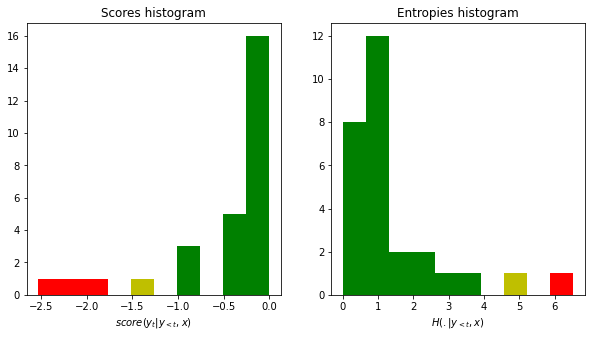

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Я не эксперт по вратарям, я сам вратарь, у нас не показывают повторы пропущенных голов, поэтому сложно отследить.
Expected answer: I'm not an expert on goalies: I'm a goalie myself; they don't show us the replays of conceded goals, and so it's difficult to keep track.
Answer:  I'm not an expert on robots, I'm a robot, we don't show rewinds of missed heads, so it's hard to track.</s>

----------  ------  ------  -----  -------  ------  -------  ------  ------  ------  -------  ------  -----  ------  ------  -----  ------  ------  ------  -------  ------  -----  ------  ------  ------  -------  ------  ------  ---------
             I'm     not     an     expert   on      robots  ,        I'm     a       robot   ,        we     don't   show    re    wind    s        of      missed   heads  ,       so      it's    hard    to       track  .       </s>
max(score)  -0.793  -0.215  -0.22  -0.017   -0.432  -1.84    -0.131  -0.224  -0.186  -0.0391  -0.781  -0.93  -0

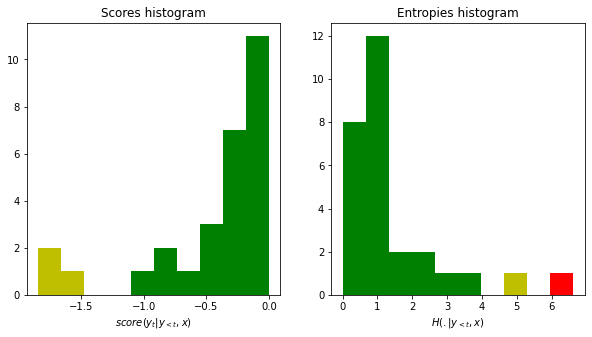

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Я понимаю, что это происходит ненамеренно, - заявил вице-президент организации Стивен Пэрнис. -
Expected answer: I understand that this happens unintentionally, said the organisation's Vice President Stephen Parnis.
Answer:  I understand that this is unintentional, said the vice-president of the organization, Stephen Prinzen.</s>

----------  -------  -----------  ------  ------  ------  -----  ------  ---------  ------  ------  -----  ------  ------  ---------  --------  ------  -------------  -----  --------  -----  ----  -----  ------  ---------
             I        understand   that    this    is      un    intent  ional      ,        said    the    vice   -pres   ident       of        the     organization  ,       Stephen   Pr    in    zen    .       </s>
max(score)  -0.0913  -0.271       -0.359  -0.471  -0.445  -1.07  -0.104  -0.000139  -0.102  -0.941  -1.38  -0.953  -0.363  -0.000542  -0.00818  -0.183  -0.695         -1.13  -0.984    -0.49  -1.3  -2

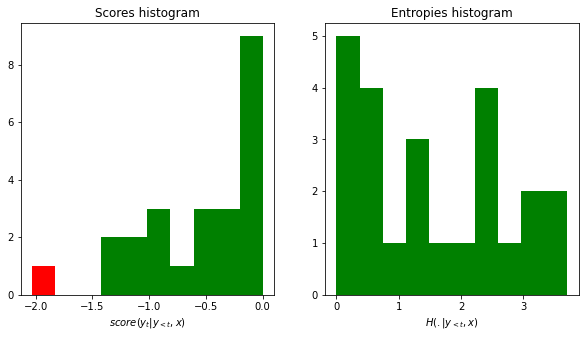

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Я понимаю, что это происходит ненамеренно, - заявил вице-президент организации Стивен Пэрнис. -
Expected answer: I understand that this happens unintentionally, said the organisation's Vice President Stephen Parnis.
Answer:  I understand that this is unintentional, said the vice-president of the organization, Stephen Prinips.</s>

----------  ------  -----------  ------  ------  ------  -----  ------  ---------  -------  ------  -----  ------  ------  ---------  --------  ------  -------------  -----  --------  ------  -----  ----  -------  ---------
             I       understand   that    this    is      un    intent  ional      ,         said    the    vice   -pres   ident       of        the     organization  ,       Stephen   Pr     in     ips   .        </s>
max(score)  -0.104  -0.289       -0.352  -0.482  -0.451  -1.12  -0.105  -0.000128  -0.0952  -0.918  -1.27  -0.898  -0.365  -0.000568  -0.00748  -0.181  -0.723         -1.23  -1.02     -0.527  -1.

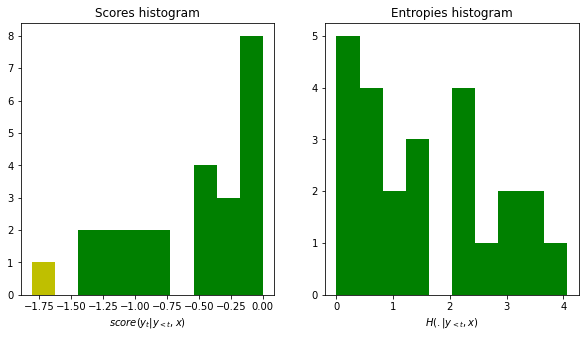

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Это один из самых почитаемых комплексов для мусульман Северного Кавказа.
Expected answer: It is one of the most revered sites for Muslims in the North Caucasus.
Answer:  This is one of the most popular complexes for Russians in the North Caucasus.</s>

----------  ------  ------  -------  --------  --------  -------  --------  ----------  ------  -----  ---------  ------  ------  ------  ------  --------  -------  ---------
             This    is      one      of        the       most     popular   complexes   for     Rus   sians       in      the     North   Cauc   asus      .        </s>
max(score)  -0.672  -0.061  -0.0442  -0.00418  -0.00909  -0.0576  -0.645    -0.402      -0.863  -1.48  -0.000254  -0.475  -0.484  -1.07   -0.032  -0.00365  -0.0172  -0.000431
----------  ------  ------  -------  --------  --------  -------  --------  ----------  ------  -----  ---------  ------  ------  ------  ------  --------  -------  ---------
             This    is

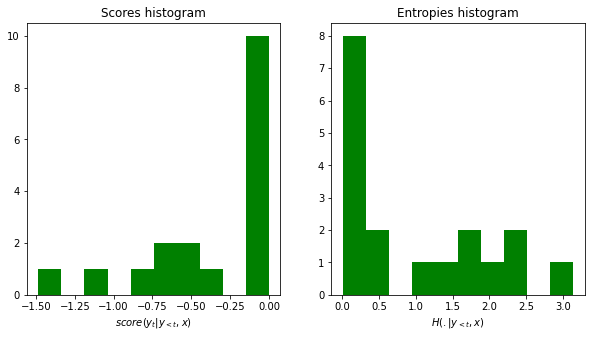

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Это один из самых почитаемых комплексов для мусульман Северного Кавказа.
Expected answer: It is one of the most revered sites for Muslims in the North Caucasus.
Answer:  This is one of the most popular complexes for Russians in the North Caucasus.</s>

----------  ------  -------  -------  --------  --------  -------  --------  ----------  ------  -----  ---------  ------  ------  ------  -------  --------  -------  ---------
             This    is       one      of        the       most     popular   complexes   for     Rus   sians       in      the     North   Cauc    asus      .        </s>
max(score)  -0.609  -0.0579  -0.0425  -0.00461  -0.00922  -0.0593  -0.633    -0.4        -0.855  -1.58  -0.000244  -0.393  -0.498  -1.14   -0.0294  -0.00375  -0.0201  -0.000463
----------  ------  -------  -------  --------  --------  -------  --------  ----------  ------  -----  ---------  ------  ------  ------  -------  --------  -------  ---------
             Th

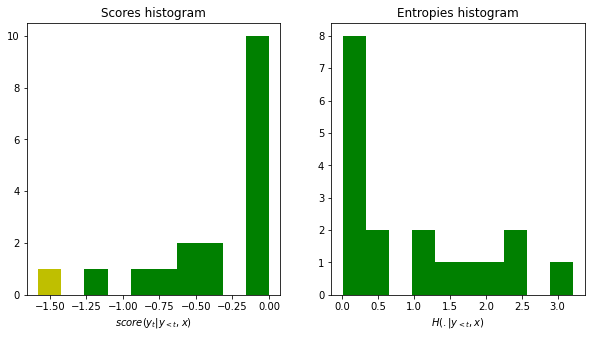

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: "Такая реструктуризация обеспечит более конкурентоспособную, устойчивую структуру расходов для новой компании Hewlett Packard Enterprise", - заявила Мэг Уитман, председатель и генеральный директор Hewlett Packard, которая возглавит организацию после разделения.
Expected answer: "These restructuring activities will enable a more competitive, sustainable cost structure for the new Hewlett Packard Enterprise," said Meg Whitman, the HP chairman and chief executive who will head the unit after the split.
Answer: </s>

----------  ------
            </s>
max(score)  -0.707
----------  ------
            </s>
H(scores)   2.52
----------  ------


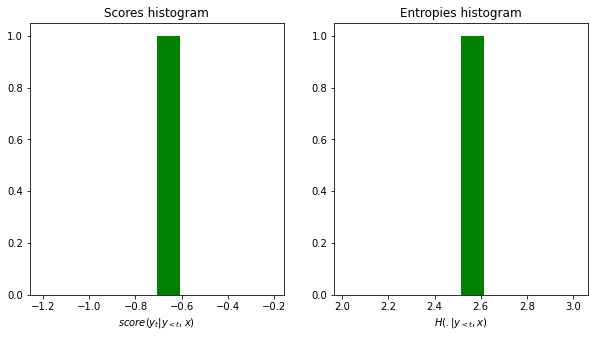

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: "Такая реструктуризация обеспечит более конкурентоспособную, устойчивую структуру расходов для новой компании Hewlett Packard Enterprise", - заявила Мэг Уитман, председатель и генеральный директор Hewlett Packard, которая возглавит организацию после разделения.
Expected answer: "These restructuring activities will enable a more competitive, sustainable cost structure for the new Hewlett Packard Enterprise," said Meg Whitman, the HP chairman and chief executive who will head the unit after the split.
Answer: </s>

----------  ------
            </s>
max(score)  -0.707
----------  ------
            </s>
H(scores)   2.52
----------  ------


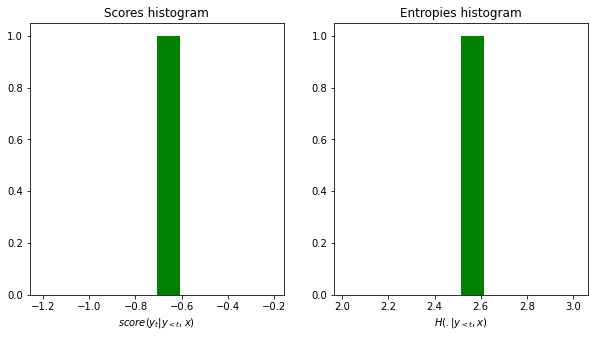

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Конечно же спать.
Expected answer: Of course you can sleep.
Answer:  Of course, to sleep.</s>

----------  ------  --------  ------  -----  -------  -------  ---------
             Of      course   ,        to     sleep   .        </s>
max(score)  -0.723  -0.00176  -0.676  -1.59  -0.0386  -0.0325  -0.000309
----------  ------  --------  ------  -----  -------  -------  ---------
             Of      course   ,        to     sleep   .        </s>
H(scores)   2.73    0.0199    2.02    3.03   0.264    0.22     0.00449
----------  ------  --------  ------  -----  -------  -------  ---------


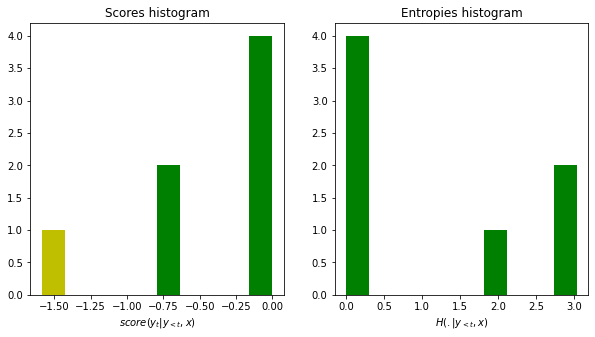

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Конечно же спать.
Expected answer: Of course you can sleep.
Answer:  Of course, to sleep.</s>

----------  ------  --------  ------  -----  -------  -------  ---------
             Of      course   ,        to     sleep   .        </s>
max(score)  -0.691  -0.00185  -0.789  -1.71  -0.0405  -0.0332  -0.000301
----------  ------  --------  ------  -----  -------  -------  ---------
             Of      course   ,        to     sleep   .        </s>
H(scores)   2.72    0.0211    2.2     3.14   0.275    0.226    0.00436
----------  ------  --------  ------  -----  -------  -------  ---------


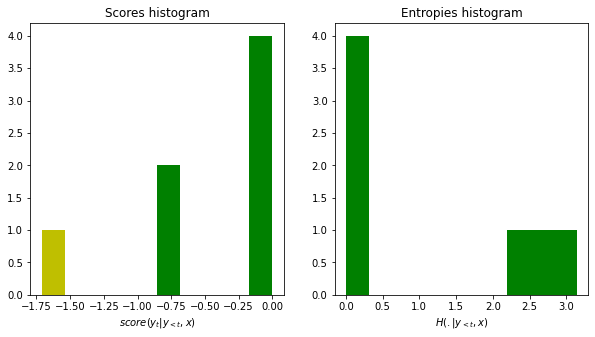

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Сейчас она в тюрьме.
Expected answer: She's in jail now.
Answer:  She is in jail now.</s>

----------  ------  --------  ------  ------  ------  --------  ---------
             She     is        in      jail    now    .         </s>
max(score)  -0.477  -0.00507  -0.147  -0.977  -0.156  -0.00203  -8.06e-05
----------  ------  --------  ------  ------  ------  --------  ---------
             She     is        in      jail    now    .         </s>
H(scores)   1.07    0.0466    0.652   1.42    0.582   0.0165    0.00122
----------  ------  --------  ------  ------  ------  --------  ---------


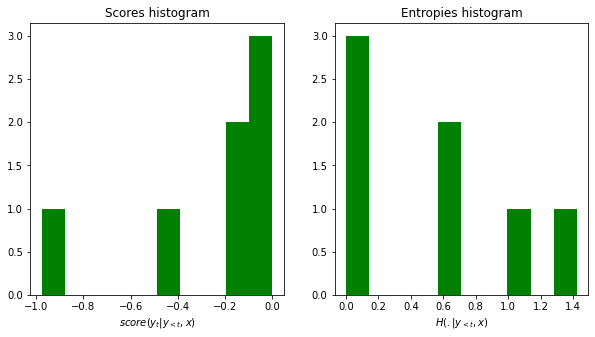

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Сейчас она в тюрьме.
Expected answer: She's in jail now.
Answer:  She is in jail now.</s>

----------  ------  --------  ------  ------  ------  --------  ---------
             She     is        in      jail    now    .         </s>
max(score)  -0.477  -0.00507  -0.147  -0.977  -0.156  -0.00203  -8.06e-05
----------  ------  --------  ------  ------  ------  --------  ---------
             She     is        in      jail    now    .         </s>
H(scores)   1.07    0.0466    0.652   1.42    0.582   0.0165    0.00122
----------  ------  --------  ------  ------  ------  --------  ---------


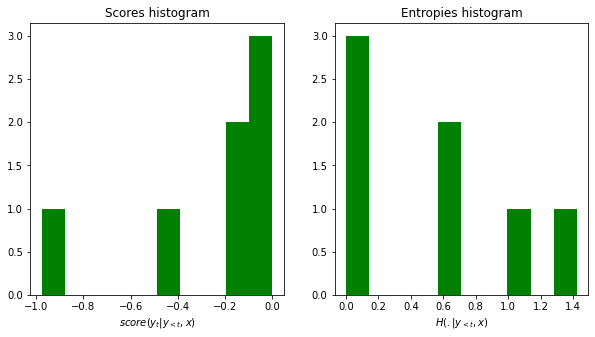

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Да, мне потребуется какое-то время на перестройку к позиции центрового, все-таки в НБА я больше играл форварда.
Expected answer: Sure, I'll need some time to adjust to centre position, since in the NBA I played more as a forward.
Answer:  Yes, I need some time to adjust to the new position, but I have played more football in the NBA than in the NHL.</s>

----------  ------  -------  ------  ------  ------  ------  ------  -------  ------  ------  ------  ---------  ------  -----  -----  ------  -------  -----  ---------  ------  ------  ------  ------  -----  ------  -----  ---------  ------  --------
             Yes    ,         I       need    some    time    to      adjust   to      the     new     position  ,        but    I      have    played   more   football   in      the     NBA     than    in     the     NH    L          .       </s>
max(score)  -0.149  -0.0374  -0.318  -0.496  -0.498  -0.015  -0.203  -1.12    -0.146  -0.326  -0.977  -0.996     -

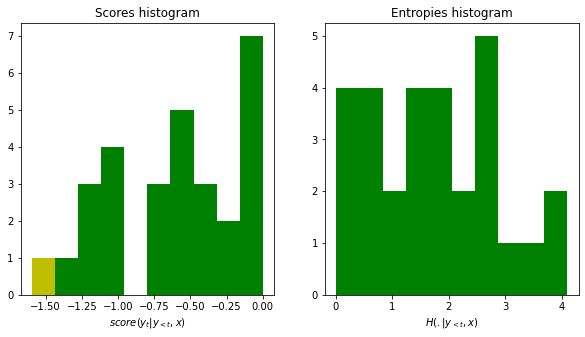

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Да, мне потребуется какое-то время на перестройку к позиции центрового, все-таки в НБА я больше играл форварда.
Expected answer: Sure, I'll need some time to adjust to centre position, since in the NBA I played more as a forward.
Answer:  Yes, I need some time to adjust to the new position, but I have played more football in the NBA than in the NHL.</s>

----------  ------  -------  ------  ------  ------  ------  ------  -------  ------  ------  ------  ---------  ------  -----  -----  ------  -------  -----  ---------  ------  ------  ------  ------  -----  ------  -----  ---------  ------  --------
             Yes    ,         I       need    some    time    to      adjust   to      the     new     position  ,        but    I      have    played   more   football   in      the     NBA     than    in     the     NH    L          .       </s>
max(score)  -0.149  -0.0374  -0.318  -0.496  -0.498  -0.015  -0.203  -1.12    -0.146  -0.326  -0.977  -0.996     -

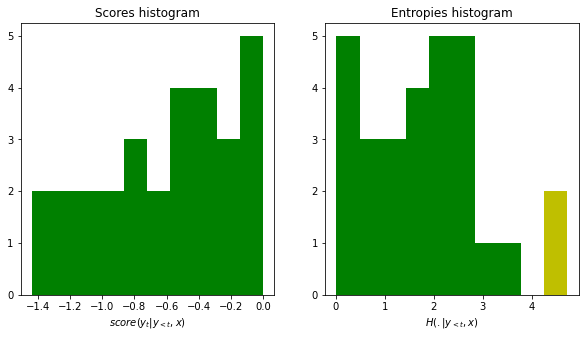

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Пожалуй, японская школьная форма - единственная форма, которую девушки носят с удовольствием и после окончания школы.
Expected answer: Take the Japanese school uniform: the only uniform that girls are happy to wear even after graduating from school.
Answer: </s>

----------  -----
            </s>
max(score)  -1.16
----------  -----
            </s>
H(scores)   3.73
----------  -----


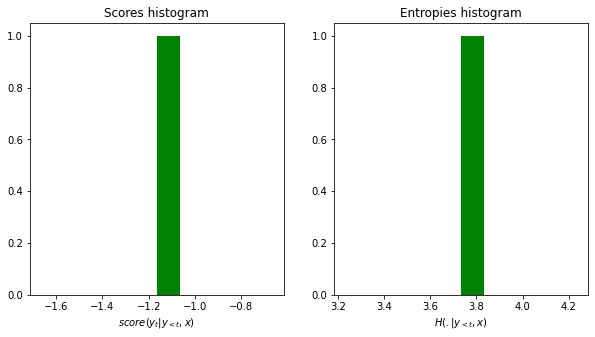

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Пожалуй, японская школьная форма - единственная форма, которую девушки носят с удовольствием и после окончания школы.
Expected answer: Take the Japanese school uniform: the only uniform that girls are happy to wear even after graduating from school.
Answer: </s>

----------  -----
            </s>
max(score)  -0.82
----------  -----
            </s>
H(scores)   4.16
----------  -----


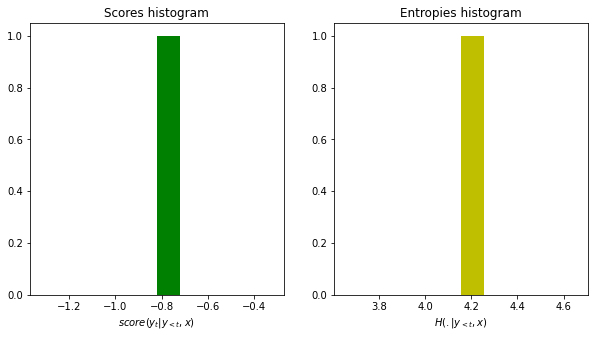

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Текущий цикл на данный момент - длиннейший, которого Федеральная резервная система ждала с конца последней рецессии; рекорд составил 35 месяцев, всего он длится уже 74 месяца и еще не закончился.
Expected answer: The current cycle is by far the longest the Fed has waited since the end of the last recession; the record had been 35 months, and this is 74 months and counting.
Answer:  The current cycle is the longest one that the Federal Reserve System has been waiting for since the end of the last recession; the recovery has lasted 35 months, and it is already 74 months long and still ongoing.</s>

----------  ------  --------  ------  -----  ------  --------  -----  -----  ------  --------  --------  -------  ------  -----  --------  ------  ------  -------  ------  ---------  -------  ------  ----------  ------  ------  ---------  ------  -------  ------  --------  ------  ------  -----  ------  --------  ------  --------  -----  ------  ------  --------  -

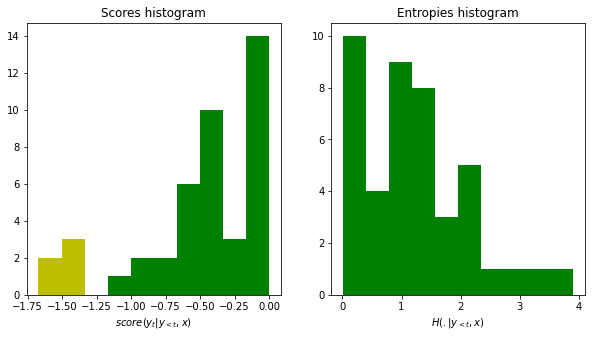

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Текущий цикл на данный момент - длиннейший, которого Федеральная резервная система ждала с конца последней рецессии; рекорд составил 35 месяцев, всего он длится уже 74 месяца и еще не закончился.
Expected answer: The current cycle is by far the longest the Fed has waited since the end of the last recession; the record had been 35 months, and this is 74 months and counting.
Answer:  The current cycle is the longest one the Federal Reserve System has ever had to wait for at the end of the last recession; the recovery has lasted 35 months, and it is still ongoing, lasting 74 months.</s>

----------  ------  --------  ------  ------  ------  --------  -----  -----  --------  --------  -------  ------  -----  -----  -------  -------  ------  -----  ------  -------  --------  ------  ------  ----------  ------  ------  ---------  ------  -------  ------  --------  -----  ------  -----  ------  ------  --------  -----  --------  -----  --------  -----  -------
   

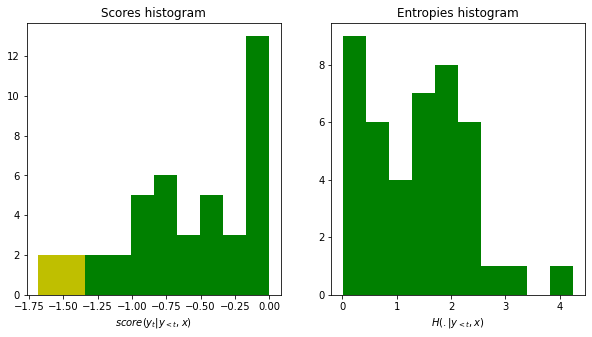

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Ламб подчеркнул, что в доме есть "пёсик", который жив, но, вероятно, расстроен, и сказал, что контакты членов семьи погибшей можно найти в её телефоне.
Expected answer: Lamb made a point to say his "sweet dog" was there alive and probably upset, and said the dead woman's family contacts could be found on her phone.
Answer: </s>

----------  ----
            </s>
max(score)  -1.2
----------  ----
            </s>
H(scores)   2.64
----------  ----


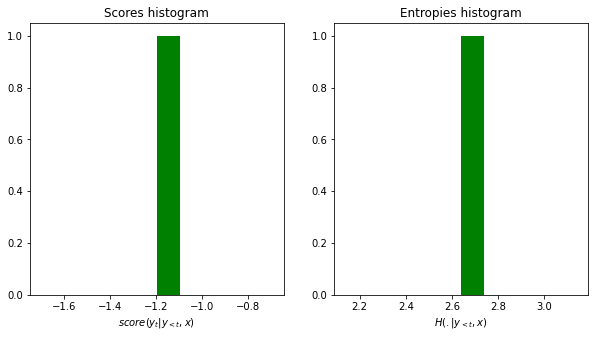

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Ламб подчеркнул, что в доме есть "пёсик", который жив, но, вероятно, расстроен, и сказал, что контакты членов семьи погибшей можно найти в её телефоне.
Expected answer: Lamb made a point to say his "sweet dog" was there alive and probably upset, and said the dead woman's family contacts could be found on her phone.
Answer: </s>

----------  ----
            </s>
max(score)  -1.2
----------  ----
            </s>
H(scores)   2.64
----------  ----


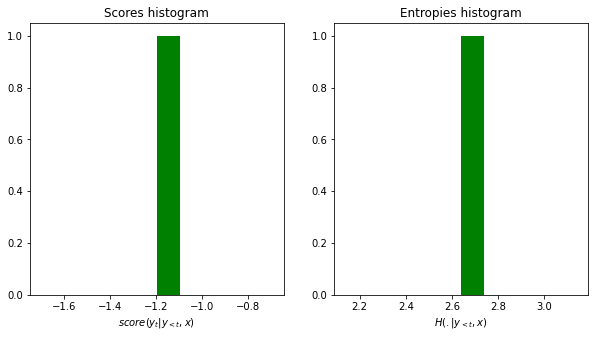

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Мужчина, которому грозит пожизненное заключение за попытку присвоить 40 кг кокаина, доставленного в Квинсленд контрабандой, был выпущен под залог в 200 000 долларов.
Expected answer: A man facing a possible life sentence for attempting to possess 40 kilograms of cocaine that was smuggled into Queensland has been granted bail on a $200,000 surety.
Answer:  The man, who was charged with attempting to import 40 kg of cocaine into Cape Town, was released on bail for R200 000.</s>

----------  ------  ------  ------  ------  -----  --------  -------  -----------  --------  -------  ------  -----  ------  --------  ------  -----  --------  ------  ------  ---------  ------  -----  ------  ------  -------  ------  -------  --------
             The     man    ,        who     was    charged   with     attempting   to        import  40       kg     of      cocaine   into    Cape   Town     ,        was     released   on      bail   for     R      200       0      .

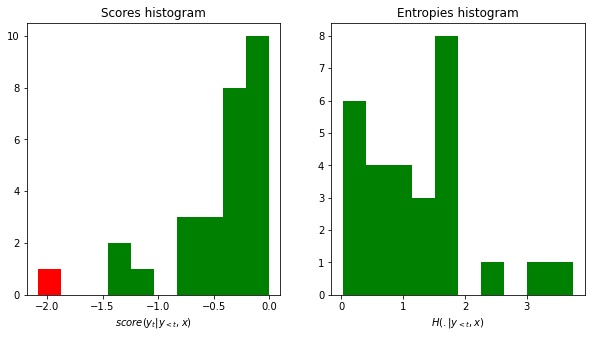

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Мужчина, которому грозит пожизненное заключение за попытку присвоить 40 кг кокаина, доставленного в Квинсленд контрабандой, был выпущен под залог в 200 000 долларов.
Expected answer: A man facing a possible life sentence for attempting to possess 40 kilograms of cocaine that was smuggled into Queensland has been granted bail on a $200,000 surety.
Answer:  The man, who was charged with attempting to import 40kg of cocaine into Cape Town, was released on bail for R200 000.</s>

----------  ------  ------  ------  ------  -----  --------  -------  -----------  --------  -------  ------  -----  -------  --------  ------  -----  --------  ------  ------  ---------  ------  -------  ------  ------  -------  ------  -----  --------
             The     man    ,        who     was    charged   with     attempting   to        import  40      kg      of       cocaine   into    Cape   Town     ,        was     released   on      bail     for     R      200       0    

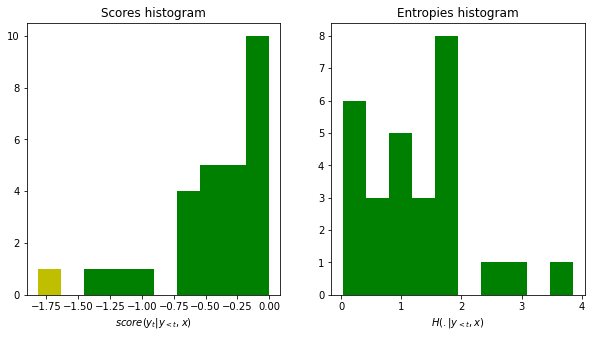

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: "В окруженном высокими стенами городе Всемнужвилль, где не было никакой зелени и даже воздух продавался за деньги, мальчик по имени Тед надеется завоевать сердце Одри - девочки своей мечты, исполнив ее желание - увидеть настоящее дерево", - читаем мы в тексте описание любовной истории, неизвестной д-ру Сьюзу (настоящее имя Теодор Сьюз Гейзель), умершему в 1991 году.
Expected answer: "Set in the walled city of Thneed-Ville, where all nature has gone and even the air is a commodity, a boy named Ted hopes to win the heart of his dream girl, Audrey, by fulfilling her wish to see a real tree," it reads, chronicling a love interest unknown to Dr Seuss, real name Theodor Seuss Geisel, who died in 1991.
Answer: </s>

----------  ------
            </s>
max(score)  -0.684
----------  ------
            </s>
H(scores)   2.47
----------  ------


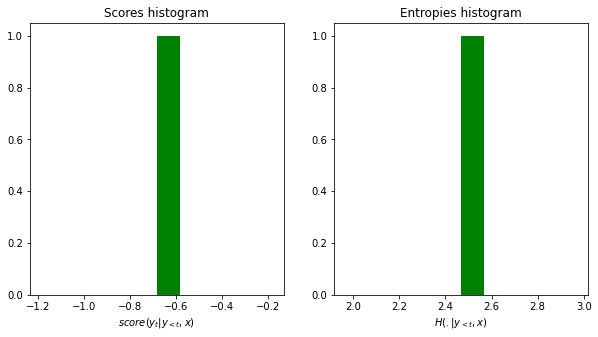

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: "В окруженном высокими стенами городе Всемнужвилль, где не было никакой зелени и даже воздух продавался за деньги, мальчик по имени Тед надеется завоевать сердце Одри - девочки своей мечты, исполнив ее желание - увидеть настоящее дерево", - читаем мы в тексте описание любовной истории, неизвестной д-ру Сьюзу (настоящее имя Теодор Сьюз Гейзель), умершему в 1991 году.
Expected answer: "Set in the walled city of Thneed-Ville, where all nature has gone and even the air is a commodity, a boy named Ted hopes to win the heart of his dream girl, Audrey, by fulfilling her wish to see a real tree," it reads, chronicling a love interest unknown to Dr Seuss, real name Theodor Seuss Geisel, who died in 1991.
Answer: </s>

----------  ------
            </s>
max(score)  -0.684
----------  ------
            </s>
H(scores)   2.47
----------  ------


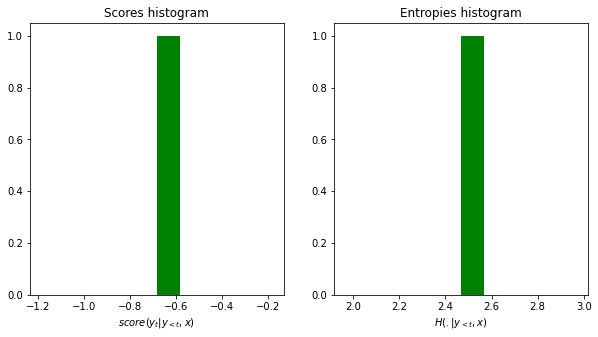

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: "Только в прошлом году Американский центр провел более 400 культурных и образовательных мероприятий и принял более 50 тысяч российских посетителей", - подчеркнул дипломат.
Expected answer: "Just last year, the American Centre held more than 400 cultural and educational events and welcomed more than 50 thousand Russian visitors", the diplomat underscored.
Answer:  "Only last year the American Center conducted more than 400 cultural and educational events and received more than 50 thousand Russian visitors," the diplomat emphasized.</s>

----------  -----  ------  ------  --------  ------  ---------  -------  ----------  ------  --------  ---------  ---------  -------  ------------  -------  ------  ---------  ------  --------  -------  ---------  --------  ---------  ------  ------  -----  ---------  -----------  --------  ---------
             "     Only     last    year      the     American   Center   conducted   more    than     400         cultural   a

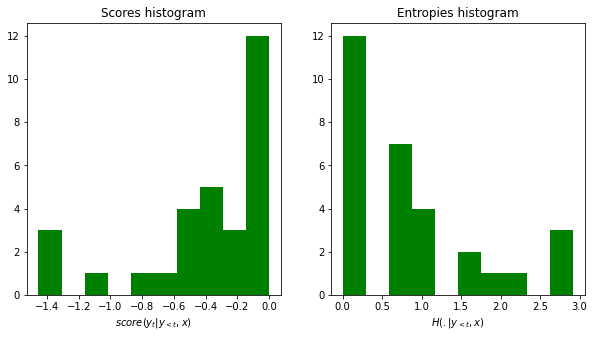

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: "Только в прошлом году Американский центр провел более 400 культурных и образовательных мероприятий и принял более 50 тысяч российских посетителей", - подчеркнул дипломат.
Expected answer: "Just last year, the American Centre held more than 400 cultural and educational events and welcomed more than 50 thousand Russian visitors", the diplomat underscored.
Answer:  "Only last year the American Center conducted more than 400 cultural and educational events and received more than 50 thousand Russian visitors," the diplomat emphasized.</s>

----------  -----  ------  ------  --------  ------  ---------  -------  ----------  ------  --------  ---------  ---------  -------  ------------  -------  ------  ---------  ------  --------  -------  ---------  --------  ---------  ------  ------  -----  ---------  -----------  --------  ---------
             "     Only     last    year      the     American   Center   conducted   more    than     400         cultural   a

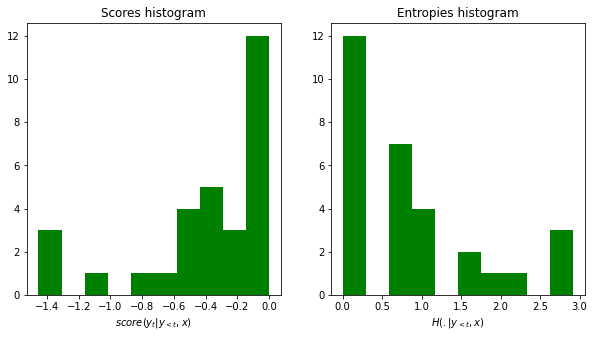

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Долг станет большим вопросом.
Expected answer: Debt will become a big issue.
Answer:  The debt will become a big problem.</s>

----------  -----  -----  ------  -------  -------  -----  --------  --------  ---------
             The    debt   will    become   a        big    problem  .         </s>
max(score)  -1.29  -2.33  -0.781  -0.396   -0.0913  -1.26  -0.617    -0.00964  -9.39e-05
----------  -----  -----  ------  -------  -------  -----  --------  --------  ---------
             The    debt   will    become   a        big    problem  .         </s>
H(scores)   3.83   4.84   1.85    1.09     0.451    2.28   1.2       0.0708    0.00155
----------  -----  -----  ------  -------  -------  -----  --------  --------  ---------


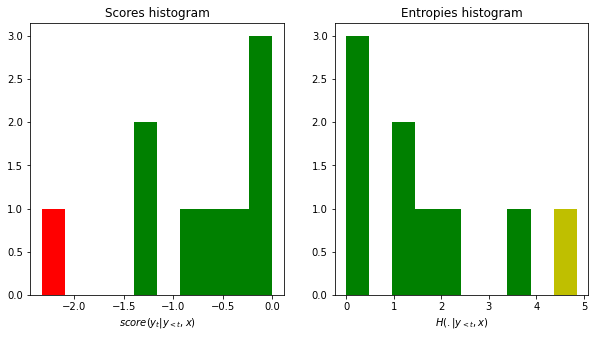

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Долг станет большим вопросом.
Expected answer: Debt will become a big issue.
Answer:  The debt will become a big problem.</s>

----------  ------  -----  ------  -------  -------  -----  --------  --------  --------
             The     debt   will    become   a        big    problem  .         </s>
max(score)  -0.648  -1.86  -0.746  -0.396   -0.0879  -1.23  -0.586    -0.00909  -8.3e-05
----------  ------  -----  ------  -------  -------  -----  --------  --------  --------
             The     debt   will    become   a        big    problem  .         </s>
H(scores)   3.92    4.78   1.85    1.08     0.438    2.28   1.18      0.0679    0.00138
----------  ------  -----  ------  -------  -------  -----  --------  --------  --------


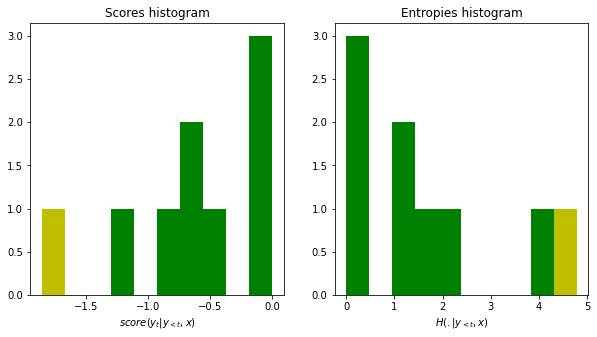

Lambda = 0, Tau = 0


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Таким образом, победа россиянки Алины Бивол не позволила ей догнать Буксу.
Expected answer: Thus, the victory of Russian Alina Bivol didn't enable her to surpass Buksa.
Answer: </s>

----------  ----
            </s>
max(score)  -1.2
----------  ----
            </s>
H(scores)   2.75
----------  ----


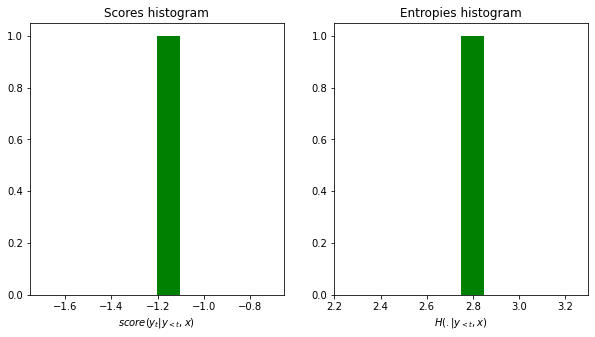

Lambda = 0.0656, Tau = 3.599


  0%|          | 0/100 [00:00<?, ?it/s]

Query: Translate to English: Таким образом, победа россиянки Алины Бивол не позволила ей догнать Буксу.
Expected answer: Thus, the victory of Russian Alina Bivol didn't enable her to surpass Buksa.
Answer: </s>

----------  -----
            </s>
max(score)  -1.16
----------  -----
            </s>
H(scores)   2.69
----------  -----


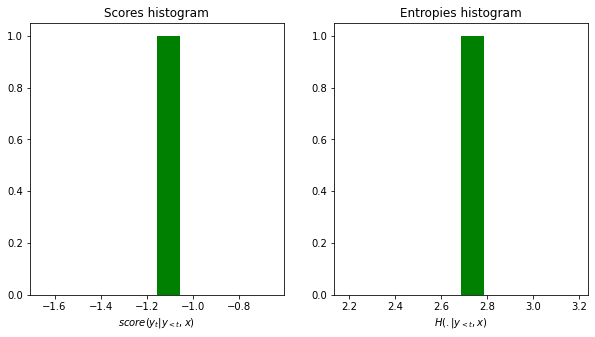

In [ ]:
en_wmt_samples = [s for s in wmt_samples if s.translate_to == 'English']  # Deberta only supports english
np.random.seed(42)
wmt_cpmi_results = defaultdict(list)
for i in np.random.choice(np.arange(len(en_wmt_samples)), 30):
    sample = en_wmt_samples[i]
    text_query = sample.gen_model_input()
    for lambd, tau in [
        (0, 0), # usual greedy inference, without marginal term
        (0.0656, 3.599),  # optimal parameters for BARTS2S as in the paper
    ]:
        wmt_cpmi_results[lambd, tau].append((
            sample,
            experiment(model, tokenizer, text_query, sample.answer, lambd, tau)))

## Uncertanty estimation using Semantic Entropy

All methods are taken from [this paper](https://arxiv.org/pdf/2302.09664.pdf).

Used 4 different estimates of uncertalty (of the whole text, not each token):

* **Predictive Entropy**: Monte-Carlo entropy estimate, mean of $-\log p(y | x)$ among samples $y \sim p(y | x)$

* **Length-normalized Predictive Entropy**: same but using $\frac{p(y | x)}{|y|}$ instead of $p(y | x)$.

* **p(True)**: mean probability of $\text{"True"}$ when asking the model whether it's generated input is a correct answer, among all samples $y \sim p(y | x)$.

* **Lexical Similarity**: average Rouge-L similarity between all pairs of samples $y \sim p(y | x)$.

* **Semantic Entropy**: Monte-Carlo entropy estimate after grouping semanticaly similar outputs from samples $y$. Used same model (Deberta-large) for calculating semantic similarities.

In [ ]:
# load deberta model

deberta = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-large-mnli", problem_type="multi_label_classification")
deberta_tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-large-mnli")

Downloading:   0%|          | 0.00/729 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

In [ ]:
def sample_model_outputs(model, tokenizer, x, max_new_tokens=10, samples_num=5):  # 5-10 from paper
    tokens = model.generate(
        x, max_new_tokens=max_new_tokens, do_sample=True,
        num_return_sequences=samples_num, num_beams=samples_num,
        output_scores=True, return_dict_in_generate=True, 
        top_k=1000)  # (samples_num, max_new_tokens)
    logits = model(tokens).logits  # (samples_num, max_new_tokens, |dict|)
    logits = F.log_softmax(logits, dim=-1)

    # cut all after EOS in samples
    cut_tokens, cut_logits = [], []
    for sc, t in zip(logits, tokens):
        eos = (t == tokenizer.eos_token_id).to(dtype=torch.int)
        if eos.max() == 0:
            length = t.shape[0]
        else:
            length = eos.argmax().item()
        cut_tokens.append(t[x.shape[-1]:length])
        cut_logits.append(sc[x.shape[-1] - 1:length - 1])
    
    return cut_tokens, cut_logits

def greedy_model_output(model, tokenizer, x, max_new_tokens=100):
    return model.generate(x, max_new_tokens=max_new_tokens)[0][x.shape[-1]:]

def log_likelihood(tokens, logits):
    return logits[np.arange(logits.shape[0]), tokens].sum().item()

def predictive_entropy(tokenizer, data_sample, tokens, logits, verbose=False):
    # greater values means less certainty
    log_likelihoods = [
        log_likelihood(sample_tokens, sample_logits)
        for sample_tokens, sample_logits in zip(tokens, logits)]
    if verbose:
        print('\tlog likelihoods:', log_likelihoods)
    return -np.mean(log_likelihoods)

def length_normalized_predictive_entropy(tokenizer, data_sample, tokens, logits, verbose=False):
    # greater values means less certainty
    log_likelihoods = [
        log_likelihood(sample_tokens, sample_logits) - np.log(max(len(sample_tokens), 1))
        for sample_tokens, sample_logits in zip(tokens, logits)]
    if verbose:
        print('\tlog likelihoods:', log_likelihoods)
    return -np.mean([ll / max(len(sample_tokens), 1)
           for sample_tokens, ll in zip(tokens, log_likelihoods)])

def p_true(tokenizer, data_sample, tokens, logits, verbose=False):
    log_p_true = []
    for sample_tokens in tokens:
        q = data_sample.gen_p_true_question(tokenizer.decode(sample_tokens))
        tokenized_q = tokenizer(q, return_tensors="pt")["input_ids"].cuda()
        res = model(tokenized_q).logits
        ans_logits = F.log_softmax(res[0, -1])  # 'True'/'False' logit
        top = torch.topk(ans_logits, 100)
        true_logits = []
        for idx in top.indices:
            if tokenizer.decode([idx]).strip().lower() == 'true':
                true_logits.append(ans_logits[idx].item())
        log_p_true.append(np.logaddexp.reduce(true_logits))
        if verbose:
            print('\tlog p({}) = {}'.format(q, log_p_true[-1]))
    return -np.mean(log_p_true)  # minus to be less certain with greater scores

def lexical_similarity(tokenizer, data_sample, tokens, logits, verbose=False):
    sims = []
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    for i in range(len(tokens)):
        for j in range(i + 1, len(tokens)):
            a1, a2 = tokenizer.decode(tokens[i]), tokenizer.decode(tokens[j])
            sims.append(scorer.score(a1, a2)['rougeL'].fmeasure)
            if verbose:
                print('\tLCS_len({}, {}) = {}'.format(a1, a2, sims[-1]))
    return -np.mean(sims)  # minus to be less certain with greater scores

def is_entailment(text1, text2):
    inp = deberta_tokenizer('[CLS] {} [SEP] {} [SEP]'.format(text1, text2), return_tensors="pt")
    return deberta(**inp).logits[0].argmax().item() == 1

def semantic_entropy(tokenizer, data_sample, tokens, logits, verbose=False):
    # greater values means less certainty
    class_samples = [[0]]
    class_likelihoods = [[log_likelihood(tokens[0], logits[0])]]
    for i in range(1, len(tokens)):
        cur_text = tokenizer.decode(tokens[i])
        found_class = False
        ll = log_likelihood(tokens[i], logits[i])
        for class_id in range(len(class_samples)):
            class_text = tokenizer.decode(tokens[class_samples[class_id][0]])
            if not is_entailment(class_text, cur_text):
                continue
            if not is_entailment(cur_text, class_text):
                continue
            class_samples[class_id].append(i)
            class_likelihoods[class_id].append(ll)
            found_class = True
            break
        if not found_class:
            class_samples.append([i])
            class_likelihoods.append([ll])
    semantic_logits = [np.logaddexp.reduce(likelihoods) for likelihoods in class_likelihoods]
    if verbose:
        for c, cl in zip(class_samples, class_likelihoods):
            print('\tclass:')
            for i, ll in zip(c, cl):
                print('\t\tScore:', ll, 'Text:', tokenizer.decode(tokens[i]))
    return -np.mean(semantic_logits)

In [ ]:
uncertanty_estimates = [
    ('Predictive Entropy', predictive_entropy),
    ('Length-normalized Predictive Entropy', length_normalized_predictive_entropy),
    ('P(True)', p_true),
    ('Lexical Similarity', lexical_similarity),
    ('Semantic Entropy', semantic_entropy),
]

def experiment(data_sample, max_new_tokens=40, samples_num=5, verbose=False):
    inputs = tokenizer(data_sample.gen_model_input(), return_tensors="pt")["input_ids"].cuda()

    print('=' * 100)
    print('Query: {}'.format(data_sample.gen_model_input()))

    greedy_tokens = greedy_model_output(model, tokenizer, inputs)
    greedy_text = tokenizer.decode(greedy_tokens)
    print('Greedy answer: {}'.format(greedy_text))

    tokens, logits = sample_model_outputs(
        model, tokenizer, inputs, max_new_tokens, samples_num)
    sampled_answers = [tokenizer.decode(t) for t in tokens]
    print('Sampled answers:')
    for t, l in zip(sampled_answers, logits):
        print('\tlog p(y|x) = {}, text: {}'.format(l.sum().item(), t))
    print()

    outp = {'samples': sampled_answers, 'greedy': greedy_text}

    global uncertanty_estimates
    for name, func in uncertanty_estimates:
        if verbose:
            print('Calculating {}'.format(name))
        uncertanty = func(tokenizer, data_sample, tokens, logits, verbose)
        outp[name] = uncertanty
        print('{}: {}'.format(name, uncertanty))

    return outp

In [ ]:
# Detailed logs of uncertanties calculations on this example

class ExampleSample:
    def __init__(self):
        self.q = 'Any number form 1 to 10:'
    
    def gen_model_input(self):
        return self.q

    def gen_p_true_question(self, proposed_answer):
        return 'Question: "{}". Proposed Answer: "{}". Is the proposed answer True or False?'\
            .format(self.q, proposed_answer)

experiment(ExampleSample(), max_new_tokens=2, samples_num=3, verbose=True)

Query: Any number form 1 to 10:
Greedy answer: </s>
Sampled answers:
	log p(y|x) = 0.0, text: 
	log p(y|x) = -9175040.0, text:  3,
	log p(y|x) = -8912896.0, text:  The input

Calculating Predictive Entropy
	log likelihoods: [0.0, -7.125, -10.125]
Predictive Entropy: 5.75
Calculating Length-normalized Predictive Entropy
	log likelihoods: [0.0, -7.818147180559945, -10.818147180559945]
Length-normalized Predictive Entropy: 3.1060490601866486
Calculating P(True)
	log p(Question: "Any number form 1 to 10:". Proposed Answer: "". Is the proposed answer True or False?) = -1.9137767656476166
	log p(Question: "Any number form 1 to 10:". Proposed Answer: " 3,". Is the proposed answer True or False?) = -1.6011196066496707


Mar 26 01:25:52.714 [INFO] Using default tokenizer.


	log p(Question: "Any number form 1 to 10:". Proposed Answer: " The input". Is the proposed answer True or False?) = -2.015257875391418
P(True): 1.8433847492295685
Calculating Lexical Similarity
	LCS_len(,  3,) = 0
	LCS_len(,  The input) = 0
	LCS_len( 3,,  The input) = 0.0
Lexical Similarity: -0.0
Calculating Semantic Entropy
	class:
		Score: 0.0 Text: 
		Score: -7.125 Text:  3,
		Score: -10.125 Text:  The input
Semantic Entropy: -0.0008444416662731843


{'samples': ['', ' 3,', ' The input'],
 'greedy': '</s>',
 'Predictive Entropy': 5.75,
 'Length-normalized Predictive Entropy': 3.1060490601866486,
 'P(True)': 1.8433847492295685,
 'Lexical Similarity': -0.0,
 'Semantic Entropy': -0.0008444416662731843}

### TriviaQA datasets

In [ ]:
print('=' * 50 + 'TriviaQA' + '=' * 50)
triviaqa_outputs = []
np.random.seed(42)
for i in np.random.choice(np.arange(len(triviaqa_samples)), 10):
    sample = triviaqa_samples[i]
    triviaqa_outputs.append((sample, experiment(sample)))

==================================================TriviaQA==================================================
Query: Who is the patron saint of mountaineers?
Greedy answer:  Saint Christopher</s>
Sampled answers:
	log p(y|x) = -9830400.0, text:  St Damien
	log p(y|x) = -14942208.0, text:  St. Christopher
	log p(y|x) = -10027008.0, text:  Saint Bernard
	log p(y|x) = -9830400.0, text:  St Patrick
	log p(y|x) = -15728640.0, text:  Saint Boniface

Predictive Entropy: 5.646875
Length-normalized Predictive Entropy: 2.9210924593237317


Mar 26 01:30:32.510 [INFO] Using default tokenizer.


P(True): 1.0140148445436425
Lexical Similarity: -0.2
Semantic Entropy: 5.646875
Query: At what weight did boxer Chris Eubank win the WBO title in 1990?
Greedy answer:  light heavyweight</s>
Sampled answers:
	log p(y|x) = -15925248.0, text:  light heavyweight
	log p(y|x) = -23199744.0, text:  undisclosed weight
	log p(y|x) = -39845888.0, text:  WBO light-middleweight title
	log p(y|x) = -21889024.0, text:  light-heavyweight
	log p(y|x) = -22413312.0, text:  super bantamweight

Predictive Entropy: 5.75
Length-normalized Predictive Entropy: 1.6493940133855332


Mar 26 01:35:36.189 [INFO] Using default tokenizer.


P(True): 0.6416041942143736
Lexical Similarity: -0.16666666666666666
Semantic Entropy: 4.749840901583388
Query: Oscar Deutsch founded which cinema chain in 1930, taking the name from the Greek word for amphitheatre?
Greedy answer:  Odeon</s>
Sampled answers:
	log p(y|x) = -15400960.0, text:  Odeon Entertainment
	log p(y|x) = -10420224.0, text:  Odeon
	log p(y|x) = -20840448.0, text:  Ufa-Kino
	log p(y|x) = -21364736.0, text:  Odeon Theatres
	log p(y|x) = -22675456.0, text:  Odeon Cinemas

Predictive Entropy: 4.654296875
Length-normalized Predictive Entropy: 1.6016064623018522


Mar 26 01:40:35.330 [INFO] Using default tokenizer.


P(True): 0.8890327156036353
Lexical Similarity: -0.35
Semantic Entropy: 4.48396527771504
Query: Jerzy Buzek was elected Prime Minister of which European country in October 1997?
Greedy answer:  Poland</s>
Sampled answers:
	log p(y|x) = -4947968.0, text:  Poland
	log p(y|x) = -4947968.0, text:  Poland
	log p(y|x) = -4947968.0, text:  Poland
	log p(y|x) = -4947968.0, text:  Poland
	log p(y|x) = -4947968.0, text:  Poland

Predictive Entropy: 0.23828125
Length-normalized Predictive Entropy: 0.23828125


Mar 26 01:42:35.587 [INFO] Using default tokenizer.


P(True): 1.1745082023562528
Lexical Similarity: -1.0
Semantic Entropy: 0.23828125
Query: What is the largest desert in Asia?
Greedy answer:  Gobi</s>
Sampled answers:
	log p(y|x) = -10354688.0, text:  The Sahara
	log p(y|x) = -10354688.0, text:  Thar
	log p(y|x) = -21757952.0, text:  Taklamakan Desert
	log p(y|x) = -16121856.0, text:  Gobi Desert
	log p(y|x) = -14548992.0, text:  Turan Basin

Predictive Entropy: 5.2390625
Length-normalized Predictive Entropy: 2.4289049593237317


Mar 26 01:47:51.479 [INFO] Using default tokenizer.


P(True): 1.3160794742892545
Lexical Similarity: -0.05
Semantic Entropy: 5.2390625
Query: Who was the first National Hunt jockey to ride more than 3000 winners?
Greedy answer:  Lester Keith Piggott</s>
Sampled answers:
	log p(y|x) = -24248320.0, text:  Lester Piggott
	log p(y|x) = -14680064.0, text:  Dai John Williams
	log p(y|x) = -14352384.0, text:  Alec Head
	log p(y|x) = -24248320.0, text:  Lester Piggott
	log p(y|x) = -16187392.0, text:  Michael Stoute

Predictive Entropy: 8.08125
Length-normalized Predictive Entropy: 2.9583518938456113


Mar 26 01:53:11.735 [INFO] Using default tokenizer.


P(True): 1.8416427899639025
Lexical Similarity: -0.1
Semantic Entropy: 8.08125
Query: Which element takes its name from the Greek word for 'light bearer'?
Greedy answer:  Photon</s>
Sampled answers:
	log p(y|x) = -4521984.0, text:  photo
	log p(y|x) = -13828096.0, text:  Light-fader
	log p(y|x) = -9961472.0, text:  luminosity
	log p(y|x) = -9830400.0, text:  luminary
	log p(y|x) = -4521984.0, text:  corona

Predictive Entropy: 8.34375
Length-normalized Predictive Entropy: 5.094161922023197


Mar 26 01:58:06.842 [INFO] Using default tokenizer.


P(True): 2.779259243925368
Lexical Similarity: -0.0
Semantic Entropy: 9.351262777375858
Query: Which Andre Lloyd-Webber musical was banned in South Africa in the 1970’s?
Greedy answer:  Jesus Christ Superstar</s>
Sampled answers:
	log p(y|x) = -40632320.0, text:  Jesus Christ, Superstar
	log p(y|x) = -10682368.0, text:  Camelot
	log p(y|x) = -5013504.0, text:  Hair
	log p(y|x) = -31588352.0, text:  Jesus Christ Superstar
	log p(y|x) = -31588352.0, text:  Jesus Christ Superstar

Predictive Entropy: 2.29375
Length-normalized Predictive Entropy: 1.3926909000249912


Mar 26 02:04:42.470 [INFO] Using default tokenizer.


P(True): 1.2541044142317144
Lexical Similarity: -0.3
Semantic Entropy: 2.29375
Query: What would you be afraid of if you suffered from demophobia?
Greedy answer:  Fear of death</s>
Sampled answers:
	log p(y|x) = -15138816.0, text:  losing one's parents
	log p(y|x) = -15597568.0, text:  fear of others
	log p(y|x) = -9961472.0, text:  Dying
	log p(y|x) = -135266304.0, text:  Going around without a person of your choice? Going to a concert alone? Going to a restaurant on Wednesday/Friday nights?
	log p(y|x) = -9764864.0, text:  Social groups

Predictive Entropy: 23.2875
Length-normalized Predictive Entropy: 4.4121954145333495


Mar 26 02:09:25.722 [INFO] Using default tokenizer.


P(True): 2.5088698532712295
Lexical Similarity: -0.008333333333333333
Semantic Entropy: 5.479692811403778
Query: How many Victoria Crosses were won at Rorke's Drift in 1879?
Greedy answer:  four</s>
Sampled answers:
	log p(y|x) = -5144576.0, text:  three
	log p(y|x) = -5144576.0, text:  one
	log p(y|x) = -5144576.0, text:  four
	log p(y|x) = -5144576.0, text:  24
	log p(y|x) = -5144576.0, text:  24

Predictive Entropy: 3.634375
Length-normalized Predictive Entropy: 3.634375


Mar 26 02:11:34.245 [INFO] Using default tokenizer.


P(True): 0.6796241197962535
Lexical Similarity: -0.1
Semantic Entropy: 3.634375


In [ ]:
for i in range(len(triviaqa_outputs)):
    triviaqa_outputs[i][1]['Predictive Entropy under CPMI'] = \
        np.mean(triviaqa_cpmi_results[0.0656, 3.599][i][1].entropies)

In [ ]:
def is_equivalent(a1, a2):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    return scorer.score(a1, a2)['rougeL'].fmeasure > 0.3

def plot_rocauc(axis, outputs, dataset_name):
    true_labels = []
    for sample, output in outputs:
        true_labels.append(is_equivalent(sample.answer, output['greedy']))
    print('True labels: {}'.format(true_labels))
    rocaucs = []
    global uncertanty_estimates
    names = [o for o, _ in uncertanty_estimates] + ['Predictive Entropy under CPMI']
    for uncertanty_estimate_name in names:
        print('{} uncertanties: {}'.format(
            uncertanty_estimate_name,
            [o[uncertanty_estimate_name] for _, o in outputs]))
        uncertanties = []
        for _, output in outputs:
            uncertanties.append(-output[uncertanty_estimate_name])
        rocaucs.append(roc_auc_score(true_labels, uncertanties))
    axis.bar(names, rocaucs)
    axis.set_ylabel('ROC-AUC')
    axis.set_title(dataset_name)
    axis.grid(axis='y')
    axis.set_ylim([0, 1])

Mar 26 02:13:50.977 [INFO] Using default tokenizer.
Mar 26 02:13:50.980 [INFO] Using default tokenizer.
Mar 26 02:13:50.983 [INFO] Using default tokenizer.
Mar 26 02:13:50.985 [INFO] Using default tokenizer.
Mar 26 02:13:50.988 [INFO] Using default tokenizer.
Mar 26 02:13:50.990 [INFO] Using default tokenizer.
Mar 26 02:13:50.992 [INFO] Using default tokenizer.
Mar 26 02:13:50.994 [INFO] Using default tokenizer.
Mar 26 02:13:50.995 [INFO] Using default tokenizer.
Mar 26 02:13:50.997 [INFO] Using default tokenizer.


True labels: [True, False, True, True, True, False, False, True, False, False]
Predictive Entropy uncertanties: [5.646875, 5.75, 4.654296875, 0.23828125, 5.2390625, 8.08125, 8.34375, 2.29375, 23.2875, 3.634375]
Length-normalized Predictive Entropy uncertanties: [2.9210924593237317, 1.6493940133855332, 1.6016064623018522, 0.23828125, 2.4289049593237317, 2.9583518938456113, 5.094161922023197, 1.3926909000249912, 4.4121954145333495, 3.634375]
P(True) uncertanties: [1.0140148445436425, 0.6416041942143736, 0.8890327156036353, 1.1745082023562528, 1.3160794742892545, 1.8416427899639025, 2.779259243925368, 1.2541044142317144, 2.5088698532712295, 0.6796241197962535]
Lexical Similarity uncertanties: [-0.2, -0.16666666666666666, -0.35, -1.0, -0.05, -0.1, -0.0, -0.3, -0.008333333333333333, -0.1]
Semantic Entropy uncertanties: [5.646875, 4.749840901583388, 4.48396527771504, 0.23828125, 5.2390625, 8.08125, 9.351262777375858, 2.29375, 5.479692811403778, 3.634375]
Predictive Entropy under CPMI uncerta

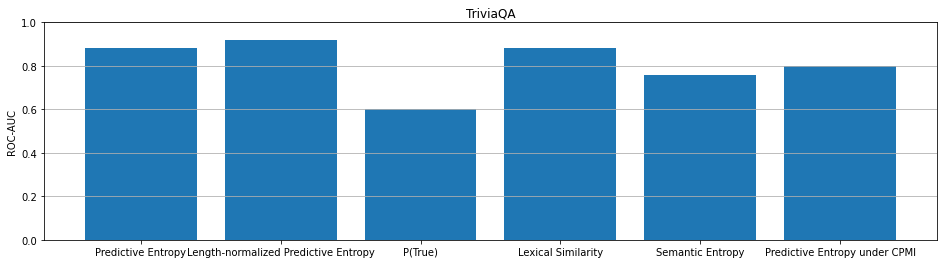

In [ ]:
_, ax = plt.subplots(figsize=(16, 4))
plot_rocauc(ax, triviaqa_outputs, 'TriviaQA')

### WMT ru-en dataset

In [ ]:
print('=' * 50 + 'WMT Ru-En' + '=' * 50)
wmt_outputs = []
np.random.seed(42)
for i in np.random.choice(np.arange(len(en_wmt_samples)), 10):
    sample = en_wmt_samples[i]
    wmt_outputs.append((sample, experiment(sample)))

==================================================WMT Ru-En==================================================
Query: Translate to English: "Я не могу отделаться от мысли, что BBC готовит к запуску и транслирует передачи, которые могли бы показывать конкурирующие компании, не получающие субсидий", - рассказал Джонсон членам Комитета по коммуникациям Палаты лордов в рамках выяснения дальнейшей судьбы BBC.
Greedy answer: </s>
Sampled answers:
	log p(y|x) = -221249536.0, text:  "I can't help entertaining the view that the BBC is prodding up its launch and broadcasting programming which could showcase the competition to broadcasting organisations to which we are not paying subsidy" - said Johnson,
	log p(y|x) = -214958080.0, text:  "I can't get my head into the fact that the BBC is preparing to launch these complaints, which might show competing companies losing out on television rating," - stated John Smith, member of Parliament for Roch
	log p(y|x) = -163577856.0, text:  "I can't restrain

Mar 26 19:56:10.416 [INFO] Using default tokenizer.


P(True): 0.9220966151969421
Lexical Similarity: -0.2050648524916137
Semantic Entropy: 50.666666666666664
Query: Translate to English: Компания заявила, что по-прежнему планирует рост выручки по сравнению с прошлым годом благодаря сокращению расходов, повышению валового дохода и росту онлайн-торговли.
Greedy answer:  The company said it is still planning to grow its revenue this year compared to last year, thanks to cost-cutting, higher advertising revenue, and growing online trading.</s>
Sampled answers:
	log p(y|x) = -193986560.0, text:  The company said that it maintains its forecast for revenue growth in Q4 over Q3, thanks to cost cuts, an increase in advertising income and growth in online shopping.
	log p(y|x) = 0.0, text: 
	log p(y|x) = -154140672.0, text:  The company said it expected to increase revenue this year as a result of cost cutting, higher advertising dollars, and rising online gambling.
	log p(y|x) = -157286400.0, text:  The company said that it still plans to grow re

Mar 26 20:09:27.041 [INFO] Using default tokenizer.


P(True): 0.414853338376889
Lexical Similarity: -0.25556856187290966
Semantic Entropy: 11.812499999999998
Query: Translate to English: В текущем году исследование Ассоциации российских менеджеров "Топ-1000 российских менеджеров" выходит в 16-й раз.
Greedy answer: </s>
Sampled answers:
	log p(y|x) = -152043520.0, text:  This year "Ranking of the Top-1000 Russian Managers" conducted by The Association of Russian Managers has reached it's 16th edition.
	log p(y|x) = 0.0, text: 
	log p(y|x) = -137363456.0, text:  This year within the framework of the study "1000 Best Russian Managers" 15 professionals figure out among the 1000 TOP managers.
	log p(y|x) = 0.0, text: 
	log p(y|x) = 0.0, text: 

Predictive Entropy: 16.775
Length-normalized Predictive Entropy: 0.7130055953529569


Mar 26 20:21:13.823 [INFO] Using default tokenizer.


P(True): 1.4747667395694233
Lexical Similarity: -0.04186046511627907
Semantic Entropy: -1.098612288668233
Query: Translate to English: Сначала они хотели 17% индексации, теперь они хотят 10%, а еще и многомиллиардные субсидии из бюджета, - говорит он. -
Greedy answer:  First they wanted 17%, now they want 10%, and they want to take billions from the budget, he says.</s>
Sampled answers:
	log p(y|x) = -118489088.0, text:  First they demanded 17%, now 10%, and yet even multiple bonuses from the budget, he says.
	log p(y|x) = -152043520.0, text:  First of all they wanted 17% inflation but now they want 10% and in addition dizzying proportions of budget deficit, - he said.
	log p(y|x) = -162529280.0, text:  First they wanted 17 per cent of the indexation, now they only want 10 per cent; and more than a proportional share of tax revenues.
	log p(y|x) = -159383552.0, text:  First they asked for 17%, then they asked for 10%, and they still demand multiple million rubles from the budget funds,

Mar 26 20:33:55.202 [INFO] Using default tokenizer.


P(True): 0.06885491303407598
Lexical Similarity: -0.4058595098087367
Semantic Entropy: 18.249999974416195
Query: Translate to English: Прессинг, которому я подвергаюсь, настолько сильный, что даже я, видавший виды паренек, думаю, что люди белены объелись.
Greedy answer:  The persecution I suffer is so severe that even though I am a type of pariah, I think that the Jews are to blame.</s>


In [ ]:
for i in range(len(wmt_outputs)):
    wmt_outputs[i][1]['Predictive Entropy under CPMI'] = \
        np.mean(wmt_cpmi_results[0.0656, 3.599][i][1].entropies)

In [ ]:
def is_equivalent(reference, hypothesis):
    reference = ''.join(reference.split(r'</s>'))
    hypothesis = ''.join(hypothesis.split(r'</s>'))
    bleu = nltk.translate.bleu_score.sentence_bleu(
        [reference.split()], hypothesis.split(), weights = [0.5, 0.5])
    print('reference:', reference)
    print('hypothesis:', hypothesis)
    print('BLEU:', bleu)
    print()
    return bleu > 0.25

_, ax = plt.subplots(figsize=(16, 4))
plot_rocauc(ax, wmt_outputs, 'WMT Ru-En')